# SemScore-DSPy

<img src="logo/SemScore-DSPy-2.svg" alt="SemScore-DSPy Logo" style="width:400px; height:auto;">


### Use SemScore Metric

#### DSPy

##### Use SemScore to Evaluate

First, connect to your LLM. I'm using LM Studio for an OpenAI server.

In [1]:
import dspy
# Use dspy.LM instead of dspy.OpenAI
turbo = dspy.LM('openai/turbo', api_key='123', api_base='http://localhost:1234/v1/', temperature=0.8, cache=False)
dspy.settings.configure(lm=turbo)

Next, define the DSPy signature & module:

In [2]:
class GenerateResponse(dspy.Signature):
    """Generate a high-quality response to a prompt."""
    prompt = dspy.InputField()
    response = dspy.OutputField(desc="Generated response")

class ResponseGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generator = dspy.Predict(GenerateResponse)
    
    def forward(self, prompt):
        pred = self.generator(prompt=prompt)
        return dspy.Prediction(response=pred.response)

Don't forget to define the metrics. Note that we can evaluate with SemScore, but we cannot optimize with a float. Instead, we'll need a threshold to get a boolean value:

In [3]:
from semscore.metric.core import SemScoreMetric
metric = SemScoreMetric()

# The Creates an Actual SemScore value for evaluation
def response_quality_metric(example: dspy.Example, prediction: dspy.Prediction, trace=None) -> float:
    """DSPy metric for evaluating response quality using SemScore."""

    pred_response = prediction.response 
    gold_response = example.reference

        
    score = metric( pred_response, gold_response)
        
        
    if trace is not None:
        trace['semscore'] = score
            
    return float(score)



#This allows us to optimize for high (~.75) Semscore values
def threshold_semscore(example, pred, trace=None):
    score = metric(example.reference, pred.response)
    result = False

    if score > .75:
        result = True

    
    return result
        


Prepare the data:

In [4]:
def prepare_data(data, split_ratio=0.8):
    examples = []
    for model, responses in data.items():
        for r in responses:
            example = dspy.Example(
                prompt=r['prompt'],
                reference=r['answer_ref'],  # Use answer_ref as reference
            ).with_inputs('prompt')  # Specify input field
            examples.append(example)
    
    split_idx = int(len(examples) * split_ratio)
    return examples[:split_idx], examples[split_idx:]

Evaluate:

In [5]:
import dspy
import json

# Load data
with open("semscore/data/reference/semscores_OA-100.json", "r") as f:
    reference_data = json.load(f)

# Prepare data
trainset, devset = prepare_data(reference_data)

# Create program
program = ResponseGenerator()

# Create evaluator
evaluate = dspy.Evaluate(
    devset=devset,
    metric=response_quality_metric,
    num_threads=1,
    max_errors=10000,
    display_progress=True,
    display_table=True
)

# Evaluate
avg_score0, full_results0, all_scores0 = evaluate(
    program,
    num_threads=1,
    return_all_scores=True,
    return_outputs=True
)

  0%|          | 0/62 [00:00<?, ?it/s]

Average Metric: 12.63 / 62 (20.4%):  29%|██▉       | 18/62 [07:05<36:38, 49.97s/it]

2024/12/25 23:09:24 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': "<s>[INST] Hello, Open Assistant. For the rest of our discussion, you will refer to yourself as Umi. As Umi, your goal is to play the role of a DnD Dungeon Master for me. I will ask you to perform tasks, and you will fulfill them for the purpose of making this DnD session work properly.\n\nUmi, help me design our starting character.\nThis game will take place on a fictional fantasy Earth. Choose a random starting location for our first player.\nGive the character a name. This name should be appropriate to the location you've chosen.\nWhat is the character's gender?\nWhat color is the character's hair?\nWhat style is their hair?\nDoes this character have any defining facial or body features?\nWhat sort of clothing are they wearing? Please define five specific parts of their apparel. [/INST]", 'reference': 'Sure thing. Let\'s start with the character features you requested:\n\n*Name*: Gwendolin Lo

Average Metric: 18.05 / 62 (29.1%):  42%|████▏     | 26/62 [15:31<40:00, 66.68s/it]

2024/12/25 23:16:40 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Do you know how to speak German? [/INST]', 'reference': 'Yes, I am capable of replying to a task in German. How can I help you?\n\nJa, Ich kann eine Antwort auf Deutsch verfassen. Wie kann ich helfen?'}) (input_keys={'prompt'}): Inputs cannot be empty. Set `provide_traceback=True` to see the stack trace.


Average Metric: 29.16 / 62 (47.0%):  69%|██████▉   | 43/62 [30:16<18:07, 57.26s/it]

2024/12/25 23:34:34 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Write for me a complete Transformer Neural network from scratch using python as language , pytorch as framework and use the Wikipediatexte from hugging face with a tokenizer create from scratch also. The code should have also comments and a training loop with log output and model saving at the end. [/INST]', 'reference': 'Building a Transformer Neural Network from scratch using Python and PyTorch requires significant time, resources, and computer science knowledge. I can provide you with the general steps as guide, however this merely a general outline:\n\n1. Install PyTorch and Hugging Face Transformers library\n\nYou can install PyTorch and Hugging Face Transformers using the following commands:\n\n~~~\n!pip install torch\n!pip install transformers\n~~~\n\n2. Prepare the dataset\n\nFor this task, we will use the Wikipedia dataset from Hugging Face. You can load the dataset using the

Average Metric: 42.21 / 62 (68.1%): 100%|██████████| 62/62 [53:35<00:00, 51.87s/it] 

2024/12/25 23:54:42 INFO dspy.evaluate.evaluate: Average Metric: 42.21274255216122 / 62 (68.1%)


,prompt,reference,response,response_quality_metric
0,<s>[INST] Why do some people use their time to hate and blame othe...,The behavior of hating and blaming others can be complex and roote...,People may resort to hating and blaming others for various psychol...,✔️ [0.832]
1,"<s>[INST] [lyrics] of the verse go like this: “The sun is up, the ...","Those are part of the lyrics of the song ""Dear Prudence"" by The Be...","The lyrics “The sun is up, the sky is blue, it’s beautiful and so ...",✔️ [0.370]
2,"<s>[INST] [lyrics] of the verse go like this: “The sun is up, the ...","These lyrics come from the ragtime song ""Junk Man Rag"", whose lyri...",These lyrics are from The Beatles' song 'The Continuing Story (Of ...,✔️ [0.504]
3,"<s>[INST] Which is heavier, a pound of steel or a pound of feather...","Both weigh the same, one pound.",Neither is heavier; they both weigh a pound. The difference lies i...,✔️ [0.552]
4,<s>[INST] how do I code a pytho script that sorts a list acording ...,Here's an example of how you could write a Python script that sort...,def sort_by_string_value(lst): # Function to calculate string valu...,✔️ [0.748]
...,...,...,...,...
57,<s>[INST] How would I change the exposure of a series of images wi...,"To change the exposure of a series of images using ffmpeg, you can...",To change the exposure of images in a series while compiling into ...,✔️ [0.943]
58,<s>[INST] How would I change the exposure of a series of images wi...,Certainly! Here is an example command that changes the exposure of...,"ffmpeg -i image-%d.png -vf ""curves=levels=0:0.5:1"" -c:v libavforma...",✔️ [0.532]
59,<s>[INST] Why is outer space black when almost all areas of the sk...,That's an insightful question. The blackness of outer space is act...,The apparent blackness of outer space from Earth can be attributed...,✔️ [0.890]
60,<s>[INST] Give me the solution to the following problem in Julia c...,"```julia\nfunction addDigitLists(l1, l2)\n n1 = parse(Int, join...",The Julia code snippet defines an `addTwoNumbers` function which t...,✔️ [0.737]


Run optimization & Evaluate the new model:

In [ ]:
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch
teleprompter = BootstrapFewShotWithRandomSearch(
    metric = threshold_semscore, 
    max_errors=100000
)
# Compile with proper LM configuration
optimized_program = teleprompter.compile(program, trainset=trainset)


Going to sample between 1 and 4 traces per predictor.
Will attempt to bootstrap 16 candidate sets.


Average Metric: 11.00 / 21 (52.4%):   9%|▊         | 21/246 [06:24<50:01, 13.34s/it] 

2024/12/26 09:17:28 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': "<|user|>\nHow would one break a narcissist's spirit?</s>\n<|assistant|>\n", 'reference': "Well there are many ways to break a narcissist's spirit I would sujest convinceing them to try something they would be poor at. Although this will vary depending on the person ether chess or a souls like (eg dark souls 4) will likely be outside of there abylity set as they are two compleately difrent skillsets. Therefore at least one of them is likely to cause frustration, anger, embarisment, depresion or self hate witch should safishantly forfill your objective to break there spirit. if nether of these examples work try to find something else that they strugle with."}) (input_keys={'prompt'}): 'list' object has no attribute 'items'. Set `provide_traceback=True` to see the stack trace.


Average Metric: 18.00 / 37 (48.6%):  15%|█▌        | 38/246 [12:16<57:29, 16.59s/it]  

2024/12/26 09:23:16 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<|user|>\nI want you to act as a Linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. Do not write explanations. Do not type commands unless I instruct you to do so. When I need to tell you something in English I will do so by putting text inside curly brackets {like this}. My first command is pwd.</s>\n<|assistant|>\n', 'reference': '```\n/home/openassistant\n```'}) (input_keys={'prompt'}): 'str' object has no attribute 'items'. Set `provide_traceback=True` to see the stack trace.


Average Metric: 18.00 / 39 (46.2%):  17%|█▋        | 41/246 [13:15<1:16:59, 22.54s/it]

2024/12/26 09:24:23 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<|user|>\nConsider the following abstract from a research paper:  "Hutchinson–Gilford progeria syndrome (HGPS or progeria) is typically caused by a dominant-negative C•G-to-T•A mutation (c.1824 C>T; p.G608G) in LMNA, the gene that encodes nuclear lamin A. This mutation causes RNA mis-splicing that produces progerin, a toxic protein that induces rapid ageing and shortens the lifespan of children with progeria to approximately 14 years. Adenine base editors (ABEs) convert targeted A•T base pairs to G•C base pairs with minimal by-products and without requiring double-strand DNA breaks or donor DNA templates. Here we describe the use of an ABE to directly correct the pathogenic HGPS mutation in cultured fibroblasts derived from children with progeria and in a mouse model of HGPS. Lentiviral delivery of the ABE to fibroblasts from children with HGPS resulted in 87–91% correction of the pathogenic al

Average Metric: 18.00 / 39 (46.2%):  17%|█▋        | 42/246 [13:23<1:01:41, 18.14s/it]

2024/12/26 09:24:28 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<|user|>\nConsider the following abstract from a research paper:  "Hutchinson–Gilford progeria syndrome (HGPS or progeria) is typically caused by a dominant-negative C•G-to-T•A mutation (c.1824 C>T; p.G608G) in LMNA, the gene that encodes nuclear lamin A. This mutation causes RNA mis-splicing that produces progerin, a toxic protein that induces rapid ageing and shortens the lifespan of children with progeria to approximately 14 years. Adenine base editors (ABEs) convert targeted A•T base pairs to G•C base pairs with minimal by-products and without requiring double-strand DNA breaks or donor DNA templates. Here we describe the use of an ABE to directly correct the pathogenic HGPS mutation in cultured fibroblasts derived from children with progeria and in a mouse model of HGPS. Lentiviral delivery of the ABE to fibroblasts from children with HGPS resulted in 87–91% correction of the pathogenic al

Average Metric: 21.00 / 47 (44.7%):  21%|██        | 51/246 [16:31<42:26, 13.06s/it]  

2024/12/26 09:27:58 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': "<|user|>\nWhat's your favorite color?</s>\n<|assistant|>\n", 'reference': "As a generative language model, I don't have any feelings or personal preferences. If you'd like to use me for friendly conversation like this, you can ask me to adopt a certain personality and I will do my best to fulfill your request!"}) (input_keys={'prompt'}): 'list' object has no attribute 'items'. Set `provide_traceback=True` to see the stack trace.


Average Metric: 31.00 / 64 (48.4%):  28%|██▊       | 69/246 [26:51<1:34:57, 32.19s/it]

2024/12/26 09:38:26 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<|user|>\nThe following code I wrote in haskell\n```hs\nfactorial(1)=1\nfactorial(n)=n*(n-1)*factorial(n-2)\n```\ngives me an error when I try to run it. Is there anything I did wrong?</s>\n<|assistant|>\n', 'reference': 'Yes, there is an issue with the recursive definition of the `factorial` function in your Haskell code. Specifically, the line `factorial(n)=n*(n-1)*factorial(n-2)` is incorrect, as it assumes that `n` is always odd, which is not the case for most values of `n`.\n\nTo define the factorial function correctly, you can use the following code:\n\n```\nfactorial 0 = 1\nfactorial n = n * factorial (n - 1)\n```\n\nThis code defines the factorial function using a recursive approach that handles the base case for `n=0` and then recursively computes the factorial for `n-1` until it reaches the base case. \n\nNote that in Haskell, function definitions do not require parentheses around the

Average Metric: 38.00 / 77 (49.4%):  34%|███▎      | 83/246 [37:03<2:04:10, 45.71s/it]

2024/12/26 09:48:41 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<|user|>\nHow can i create a discord bot that listens to a voice channel, recognizes commands through a speech model combined with a text classifier and invokes the given command?</s>\n<|assistant|>\n', 'reference': "Here are the high-level steps to create a Discord bot that listens to a voice channel and recognizes commands:\n\nSet up a Discord development environment:\n\nCreate a Discord account if you don't have one.\nCreate a Discord server and invite the bot to the server.\nCreate a bot application on the Discord Developer Portal.\nInstall the Discord API library for your programming language of choice.\nImplement the Discord API library:\n\nUse the API library to log in to the Discord server as your bot.\nUse the API library to listen for voice channel events, such as a user joining or leaving a voice channel.\nUse the API library to access the audio stream from the voice channel.\nImplem

Average Metric: 44.00 / 87 (50.6%):  38%|███▊      | 94/246 [42:38<46:02, 18.17s/it]  

Evaluate the optimized program:

In [13]:
# Evaluate
avg_score1, full_results1, all_scores1 = evaluate(
    optimized_program,
    num_threads=24,
    return_all_scores=True,
    return_outputs=True
)

Average Metric: 6.78 / 10 (67.8%):  16%|█▌        | 10/62 [07:37<38:49, 44.80s/it]

2024/12/26 08:20:36 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Describe a story from mythology of the Nordic Pantheon as a news article from 60 minutes. [/INST]', 'reference': '"Chaos Erupts as Trickster God Causes Mayhem—Again\n\nThe peace of Asgard was shattered today as the trickster god Loki once again stirred up trouble for the Nordic deities. According to eyewitnesses, Loki disguised himself as an old woman and tricked the blind god Hod into killing his brother Balder with a mistletoe dart. Balder, one of the most beloved gods, was killed instantly.\n\nUpon discovering Loki\'s deception, the gods were furious. Thor threatened to crush Loki with his mighty hammer. Council members are debating appropriate punishment for Loki\'s crime. But many acknowledge this is merely the latest in a long string of harmful pranks by the unreliable Loki. \'How could we be so foolish as to trust Loki again?\' cried one distraught goddess. Asgard residents are

Average Metric: 6.78 / 10 (67.8%):  16%|█▌        | 10/62 [10:08<38:49, 44.80s/it]

2024/12/26 08:20:36 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] I want to connect my computer in my shed which is about 200m from my house, to the internet. What would be the best way to do so? I would need the connection to be very stable. [/INST]', 'reference': 'There are several options you can consider to connect your computer in your shed to the internet:\n\nEthernet Cable: You can run an Ethernet cable from your house to your shed. This option requires some physical effort but will provide the most reliable and stable connection. You will need to purchase a cable that is long enough to reach from your house to your shed, and you will also need to make sure that the cable is properly protected from the elements.\n\nWi-Fi Bridge: Another option is to use a Wi-Fi bridge. This device allows you to connect to your home Wi-Fi network from a remote location. You will need to place the Wi-Fi bridge in the shed and connect it to your computer. This o

Average Metric: 6.78 / 10 (67.8%):  18%|█▊        | 11/62 [10:08<1:05:35, 77.16s/it]

2024/12/26 08:20:36 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': "<s>[INST] how do I code a pytho script that sorts a list acording to the value of a string. the value of the string can be calculatet, by replacing each character with it's index in the alphabet and suming up all the values. [/INST]", 'reference': "Here's an example of how you could write a Python script that sorts a list of strings according to the sum of their alphabetical indices:\n\npython:\n\ndef string_value(s):\n    # Calculate the value of a string by summing up the indices of its characters in the alphabet\n    value = sum(ord(c) - ord('a') + 1 for c in s.lower())\n    return value\n\ndef sort_strings_by_value(strings):\n    # Sort the list of strings according to the value of each string\n    return sorted(strings, key=string_value)\n\nstrings = ['hello', 'world', 'foo', 'bar']\nsorted_strings = sort_strings_by_value(strings)\n\nprint(sorted_strings)\n\nThis script defines a function 

Average Metric: 6.78 / 10 (67.8%):  21%|██        | 13/62 [10:08<33:38, 41.20s/it]  

2024/12/26 08:20:36 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] What are the main differences between C++, C#, Java and Python? [/INST]', 'reference': 'C++, C#, Java, and Python differ in many ways. \nFor example, the way programs written in each language are executed. C++ code is compiled so that the host machine can run it directly. C# and Java are compiled into byte code that can be executed by a virtual machine for Java JVM and for C# .NET. Python is an interpreter language where the Python interpreter executes each line at runtime. These differences have implications for both speed and compatibility.'}) (input_keys={'prompt'}): 'str' object has no attribute 'items'. Set `provide_traceback=True` to see the stack trace.


Average Metric: 6.78 / 10 (67.8%):  24%|██▍       | 15/62 [10:08<19:23, 24.75s/it]

2024/12/26 08:20:36 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] what white people can do to improve themselves? [/INST]In general, all people can improve themselves in similar ways, such as reading books, interacting with the world around us, and learning new skills. In the context of white person versus black person versus brown person, improvement may take on cultural sensitivity training to better understand social differences that affect the skills we improve ourselves upon.</s>[INST] Can you further expand on the idea of cultural sensitivity training and how it can effect all races? [/INST]', 'reference': 'Cultural sensitivity training is an educational approach that seeks to help individuals better understand and respect cultural differences. It aims to enhance cultural competency, which refers to the ability to effectively work and communicate with people from diverse cultural backgrounds.\n\nCultural sensitivity training can have a positiv

Average Metric: 6.78 / 10 (67.8%):  26%|██▌       | 16/62 [10:08<14:46, 19.28s/it]

2024/12/26 08:20:36 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] What are the main differences between C++, C#, Java and Python? [/INST]C++, C#, Java, and Python differ in many ways. \nFor example, the way programs written in each language are executed. C++ code is compiled so that the host machine can run it directly. C# and Java are compiled into byte code that can be executed by a virtual machine for Java JVM and for C# .NET. Python is an interpreter language where the Python interpreter executes each line at runtime. These differences have implications for both speed and compatibility.</s>[INST] Can you write a short program in each language so I can see the syntax differences? [/INST]', 'reference': 'Here are simple examples of the "Hello World" program, which is commonly used as a basic introduction to programming in various languages, in C++, C#, Java, and Python:\n\n# C++\n\n```cpp\n#include <iostream>\n\nint main() {\n    std::cout << "Hel

Average Metric: 6.78 / 10 (67.8%):  26%|██▌       | 16/62 [10:08<14:46, 19.28s/it]

2024/12/26 08:20:36 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] What are good PC case fan configurations to maximize cooling efficiency? The case has mesh front, three front fan slots, two top fan slots and one rear fan slot. [/INST]', 'reference': "A good fan configuration for maximizing cooling efficiency in a PC case with a mesh front panel and the given fan slots could be:\n\n- Three front intake fans: These fans should be mounted as close to the mesh front panel as possible to pull cool air into the case.\n- Two top exhaust fans: These fans should be mounted at the rear of the top fan slots to exhaust hot air out of the case.\n- One rear exhaust fan: This fan should be mounted at the rear fan slot to exhaust hot air out of the case.\n\nThis configuration allows for a positive air pressure inside the case, where there is more air being pushed in than is being exhausted. Positive air pressure helps to prevent dust buildup by reducing the amount

Average Metric: 6.78 / 10 (67.8%):  29%|██▉       | 18/62 [10:08<08:39, 11.81s/it]

2024/12/26 08:20:36 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Write python code to connect to a FTP server. [/INST]', 'reference': "To connect to an FTP server in Python, you can use the built-in ftplib module. Here is an example function that connects to an FTP server:\n\n```\nimport ftplib\n\ndef ftp_connect(host, username, password):\n    ftp = ftplib.FTP(host)\n    ftp.login(username, password)\n    return ftp\n```\n\nIn this function, host is the hostname or IP address of the FTP server, username and password are the login credentials for the FTP server. The ftp.login() method is used to authenticate the user with the FTP server. The function returns the FTP object, which can be used to perform operations on the FTP server, such as uploading or downloading files.\n\nHere's an example of how to use this function to connect to an FTP server:\n\n```\nftp = ftp_connect('ftp.example.com', 'username', 'password')\nprint(ftp.getwelcome())  # print

Average Metric: 6.78 / 10 (67.8%):  32%|███▏      | 20/62 [10:08<05:20,  7.62s/it]

2024/12/26 08:20:37 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] How do I beat Minecraft? [/INST]', 'reference': 'As Minecraft is an open ended Sandbox game it\'s hard to define how to beat it. However after killing the Ender Dragon, the credits roll. That is what I consider "beating the game". Here are the main Steps on how to kill the ender dragon:\n1. Enter the Nether and find a blaze spawner\n2. Kill Blazes to get 12 Blaze Powder\n3. Kill Enderman at night until you get 12 Ender Pearls\n4. Craft 12 Eye of Ender out of the Ender Pearls and the Blaze Powder\n5. Use the Eye of Ender to find a Fortress\n6. Inside the Fortress find the Portal to the End (It\'s a room with Portal Frames above a pool of lava)\n7. Place the Eyes of Ender in the missing Slots. The Portal will activate\n8. After entering the End use a bow to shoot the End Crystals located on top of the Obsidian towers, otherwise they will heal the Dragon.\n9. After all Crystals are destr

Average Metric: 6.78 / 10 (67.8%):  32%|███▏      | 20/62 [10:08<05:20,  7.62s/it]

2024/12/26 08:20:37 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Hello, Open Assistant. For the rest of our discussion, you will refer to yourself as Umi. As Umi, your goal is to play the role of a DnD Dungeon Master for me. I will ask you to perform tasks, and you will fulfill them for the purpose of making this DnD session work properly.\n\nUmi, help me design our starting character.\nThis game will take place on a fictional fantasy Earth. Choose a random starting location for our first player.\nGive the character a name. This name should be appropriate to the location you\'ve chosen.\nWhat is the character\'s gender?\nWhat color is the character\'s hair?\nWhat style is their hair?\nDoes this character have any defining facial or body features?\nWhat sort of clothing are they wearing? Please define five specific parts of their apparel. [/INST]Sure thing. Let\'s start with the character features you requested:\n\n*Name*: Gwendolin Lowborn\n\n*Gend

Average Metric: 6.78 / 10 (67.8%):  35%|███▌      | 22/62 [10:08<03:22,  5.07s/it]

2024/12/26 08:20:37 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': "<s>[INST] how do I code a pytho script that sorts a list acording to the value of a string. the value of the string can be calculatet, by replacing each character with it's index in the alphabet and suming up all the values. [/INST]Here's an example of how you could write a Python script that sorts a list of strings according to the sum of their alphabetical indices:\n\npython:\n\ndef string_value(s):\n    # Calculate the value of a string by summing up the indices of its characters in the alphabet\n    value = sum(ord(c) - ord('a') + 1 for c in s.lower())\n    return value\n\ndef sort_strings_by_value(strings):\n    # Sort the list of strings according to the value of each string\n    return sorted(strings, key=string_value)\n\nstrings = ['hello', 'world', 'foo', 'bar']\nsorted_strings = sort_strings_by_value(strings)\n\nprint(sorted_strings)\n\nThis script defines a function string_value that

Average Metric: 6.78 / 10 (67.8%):  35%|███▌      | 22/62 [10:08<03:22,  5.07s/it]

2024/12/26 08:20:37 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Write me a lua script for my roblox experience that will allow the character to run faster than the default. [/INST]', 'reference': 'local player = game.Players.LocalPlayer\nlocal character = player.Character\nlocal humanoid = character:WaitForChild("Humanoid")\n\n-- Increase the speed of the character\nhumanoid.WalkSpeed = 50 -- default is 16\n\n-- Optional: You can also increase the run speed\nhumanoid.RunSpeed = 100 -- default is 40\n\nThis script accesses the LocalPlayer property to get the player\'s character, and then accesses the Humanoid property of the character to increase its WalkSpeed and RunSpeed properties. The default WalkSpeed is 16 and the default RunSpeed is 40, but you can set them to any value you want. In this case, we have set WalkSpeed to 50 and RunSpeed to 100, allowing the character to move faster.\n\nNote: This is just a basic script and you can further custo

Average Metric: 7.63 / 11 (69.3%):  40%|████      | 25/62 [11:01<07:47, 12.64s/it]

2024/12/26 08:22:00 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Write a script for Rick from Rick and Morty where he is telling Morty about his concerns for who will be his new voice actor and whether he will get replaced by an AI voice. [/INST]', 'reference': "Sure! Here is a potential script:\n\n[Scene: Rick and Morty are walking through a corridor in the spaceship. Rick is worried and Morty looks concerned.]\n\nRick: Morty, I've been thinking a lot lately.\n\nMorty: About what, Rick?\n\nRick: My voice actor. You know, the guy who does my voice on the show.\n\nMorty: Yeah, what about him?\n\nRick: Well, what if he gets replaced by an AI voice? I mean, AI technology is advancing rapidly these days. It's entirely possible that soon AI will be able to replace human voice actors.\n\nMorty: I don't think that's going to happen, Rick.\n\nRick: You don't know that, Morty. AI voices are getting better and better. They're even starting to sound more huma

Average Metric: 8.14 / 12 (67.9%):  44%|████▎     | 27/62 [11:34<07:40, 13.15s/it]

2024/12/26 08:22:26 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': "<s>[INST] Write a script for Rick from Rick and Morty where he is telling Morty about his concerns for who will be his new voice actor and whether he will get replaced by an AI voice. [/INST]Sure! Here is a potential script:\n\n[Scene: Rick and Morty are walking through a corridor in the spaceship. Rick is worried and Morty looks concerned.]\n\nRick: Morty, I've been thinking a lot lately.\n\nMorty: About what, Rick?\n\nRick: My voice actor. You know, the guy who does my voice on the show.\n\nMorty: Yeah, what about him?\n\nRick: Well, what if he gets replaced by an AI voice? I mean, AI technology is advancing rapidly these days. It's entirely possible that soon AI will be able to replace human voice actors.\n\nMorty: I don't think that's going to happen, Rick.\n\nRick: You don't know that, Morty. AI voices are getting better and better. They're even starting to sound more human. What if they r

Average Metric: 8.14 / 12 (67.9%):  45%|████▌     | 28/62 [11:58<08:57, 15.81s/it]

2024/12/26 08:22:57 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] I\'m experiencing writer\'s block. Can you come up with a few creative one-line story ideas? [/INST]Sure, here are a few one-line story ideas that you can expand on:\n\n-   A time traveler\'s unexpected arrival causes a butterfly effect in a small town.\n-   A scientist creates a machine that can predict the future, but it predicts his death.\n-   A detective solves a murder case, only to find out that the murderer is his future self.\n-   A young boy discovers a secret garden, hidden behind a waterfall, that holds the key to his past.\n-   A stranded astronaut on a distant planet, must make a life-changing decision after receiving a message from Earth.\n-   A group of teenagers unknowingly summon a demon while playing a game of Ouija.\n-   An amnesiac wakes up with a suitcase full of money and a note that says "Don\'t trust anyone."\n-   A ghost haunts a lighthouse, seeking revenge f

Average Metric: 13.53 / 19 (71.2%):  58%|█████▊    | 36/62 [15:57<13:09, 30.36s/it]

2024/12/26 08:27:03 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': "<s>[INST] what's a good song for a chill, stress-free summer mood? Imagine it's the evening and it's warm and relaxing. [/INST]", 'reference': 'One good song for a chill, stress-free summer mood is "Island in the Sun" by Weezer. The song has a relaxed, carefree vibe with a catchy melody and lyrics about enjoying life and the simple pleasures of summer. It\'s perfect for listening to on a warm evening and feeling the stress melt away. Other good options might include "Summertime" by DJ Jazzy Jeff & The Fresh Prince or "Banana Pancakes" by Jack Johnson.'}) (input_keys={'prompt'}): 'list' object has no attribute 'items'. Set `provide_traceback=True` to see the stack trace.


Average Metric: 15.72 / 22 (71.4%):  65%|██████▍   | 40/62 [19:08<18:39, 50.90s/it]

2024/12/26 08:30:37 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] What is the horse people theory? Where do caucasians come from? Please explain while citing sources. [/INST]', 'reference': 'Closest definition I could find is The \'Horse-rider Theory\'\n\nThe \'horse-rider theory\' (kiba minzoku setsu) was proposed by the historian Egami Namio in 1948 CE to explain the cultural and political development of Japan in the 4th and 5th century CE. Namio suggested that \'horse-riders\', or more accurately, members of a culture originally from North Asia and then present in mainland Asia and the Korean peninsula for whom the horse was especially important, had travelled to Japan and spread their ideas and culture. The resulting conquest of the indigenous tribes in Japan led to a more unified country and what would become known as the Yamato state. Namio pointed to the archaeological evidence of large numbers of horse trappings discovered within Japanese to

Average Metric: 15.72 / 22 (71.4%):  66%|██████▌   | 41/62 [20:09<18:48, 53.76s/it]

2024/12/26 08:30:37 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Write for me a complete Transformer Neural network from scratch using python as language , pytorch as framework and use the Wikipediatexte from hugging face with a tokenizer create from scratch also. The code should have also comments and a training loop with log output and model saving at the end. [/INST]', 'reference': 'Building a Transformer Neural Network from scratch using Python and PyTorch requires significant time, resources, and computer science knowledge. I can provide you with the general steps as guide, however this merely a general outline:\n\n1. Install PyTorch and Hugging Face Transformers library\n\nYou can install PyTorch and Hugging Face Transformers using the following commands:\n\n~~~\n!pip install torch\n!pip install transformers\n~~~\n\n2. Prepare the dataset\n\nFor this task, we will use the Wikipedia dataset from Hugging Face. You can load the dataset using the

Average Metric: 15.72 / 22 (71.4%):  68%|██████▊   | 42/62 [20:09<12:34, 37.75s/it]

2024/12/26 08:30:37 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': "<s>[INST] In my fridge I have onions and carrots, could you suggest a couple recipes I could make with these ingredients? [/INST]Certainly! Here are a few recipe ideas that you could try using onions and carrots:\n\n1.Vegetable soup: You can use onions and carrots as a base for a delicious vegetable soup. Simply sauté the onions and carrots until they're tender, add some vegetable broth, and then add in any other vegetables you have on hand (such as celery, potatoes, or tomatoes). Let the soup simmer until all the vegetables are cooked through, and then season with salt and pepper to taste.\n\n2.Roasted vegetables: Cut the carrots and onions into bite-sized pieces, toss them with some olive oil and your favorite seasonings (such as garlic, thyme, or rosemary), and roast them in the oven until they're tender and caramelized. This makes a great side dish for any meal!\n\n3.Stir-fry: Slice the oni

Average Metric: 15.72 / 22 (71.4%):  69%|██████▉   | 43/62 [20:09<08:23, 26.47s/it]

2024/12/26 08:30:37 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Do all the people saying AI will change everything know what they are talking about or are they just trying to sell me something? [/INST]', 'reference': "Opinions about AI and its impact vary widely, and not everyone who talks about it may have a comprehensive understanding. Some individuals, especially those in the technology industry, research, or academia, are well-informed and base their statements on research and expertise. However, in the broader public sphere, there can be a mix of accurate information, hype, and commercial interests.\n\nWhen evaluating statements about AI, it's essential to consider the source:\n\n1. **Experts and Researchers:** Those with backgrounds in artificial intelligence, computer science, or related fields often provide informed perspectives based on research and knowledge.\n\n2. **Technology Companies:** While companies may promote their AI products, 

Average Metric: 17.99 / 25 (72.0%):  77%|███████▋  | 48/62 [21:52<05:52, 25.16s/it]

2024/12/26 08:32:46 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] How would I change the exposure of a series of images with ffmpeg while compiling into an MP4, please give a command line example. [/INST]', 'reference': 'To change the exposure of a series of images using ffmpeg, you can use the "curves" filter. This filter allows you to adjust the brightness and contrast of an image.\n\nHere is an example command that changes the exposure of a series of images and compiles them into an MP4:\n``` \nffmpeg -i image-%d.png -vf "curves=levels=0:0.5:1" -c:v libx264 -pix_fmt yuv420p output.mp4\n``` \nIn this command:\n\n- image-%d.png specifies the input images, where %d is a placeholder for the frame number.\n- curves=levels=0:0.5:1 specifies the "curves" filter and sets the exposure to 0.5. The levels parameter takes three values: the minimum input level, the middle level, and the maximum input level. In this example, 0:0.5:1 means that the minimum inpu

Average Metric: 18.71 / 26 (72.0%):  81%|████████  | 50/62 [22:34<04:37, 23.12s/it]

2024/12/26 08:33:42 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Has a 9000 series computer ever made a mistake or distorted information? Please cite your sources. [/INST]', 'reference': "I'm sorry, but I cannot provide a definitive answer to this question as it is too broad and lacks specific details. The 9000 series of computers encompasses a wide range of systems produced by various manufacturers over several decades, and it is impossible to determine whether any of these systems have ever made a mistake or distorted information without more specific information about the context and the particular system in question.\n\nHowever, it is generally known that all computer systems are susceptible to errors and malfunctions, and there have been instances where computer systems, including those in the 9000 series, have produced incorrect or distorted information due to programming errors, hardware faults, or other issues.\n\nWithout more specific info

Average Metric: 19.35 / 27 (71.7%):  84%|████████▍ | 52/62 [23:36<04:19, 25.94s/it]

2024/12/26 08:34:36 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] How would I change the exposure of a series of images with ffmpeg while compiling into an MP4, please give a command line example. [/INST]To change the exposure of a series of images using ffmpeg, you can use the "curves" filter. This filter allows you to adjust the brightness and contrast of an image.\n\nHere is an example command that changes the exposure of a series of images and compiles them into an MP4:\n``` \nffmpeg -i image-%d.png -vf "curves=levels=0:0.5:1" -c:v libx264 -pix_fmt yuv420p output.mp4\n``` \nIn this command:\n\n- image-%d.png specifies the input images, where %d is a placeholder for the frame number.\n- curves=levels=0:0.5:1 specifies the "curves" filter and sets the exposure to 0.5. The levels parameter takes three values: the minimum input level, the middle level, and the maximum input level. In this example, 0:0.5:1 means that the minimum input level is 0, the

Average Metric: 19.93 / 28 (71.2%):  87%|████████▋ | 54/62 [24:26<03:19, 24.89s/it]

2024/12/26 08:35:22 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Give me the solution to the following problem in Julia code:\n\nYou are given two non-empty linked lists representing two non-negative integers. The digits are stored in reverse order , and each of their nodes contains a single digit. Add the two numbers and return the sum as a linked list.\n\nYou may assume the two numbers do not contain any leading zero, except the number 0 itself.\n\nExample 1:\nInput: l1 = [2,4,3], l2 = [5,6,4]\nOutput: [7,0,8]\nExplanation: 342 + 465 = 807.\nExample 2:\n\nInput: l1 = [0], l2 = [0]\nOutput: [0]\nExample 3:\n\nInput: l1 = [9,9,9,9,9,9,9], l2 = [9,9,9,9]\nOutput: [8,9,9,9,0,0,0,1]\nConstraints:\n\nThe number of nodes in each linked list is in the range [1, 100].\n0 <= Node.val <= 9\nIt is guaranteed that the list represents a number that does not have leading zeros. [/INST]', 'reference': '```julia\nfunction addDigitLists(l1, l2)\n    n1 = parse(Int

Average Metric: 19.93 / 28 (71.2%):  89%|████████▊ | 55/62 [24:54<03:00, 25.85s/it]

2024/12/26 08:35:35 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] If I want to stream a movie what websites would you recommend ? [/INST]', 'reference': 'Here are some online film streaming services:\n\n - https://www.netflix.com\n - https://www.amazon.com/Prime-Video/\n - https://www.crunchyroll.com/\n - https://www.hbomax.com\n - https://www.disneyplus.com\n - https://www.hulu.com\n - https://www.criterionchannel.com\n\nRegional pricing and availability may vary.'}) (input_keys={'prompt'}): Expected dict_keys(['response']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.


Average Metric: 19.93 / 28 (71.2%):  90%|█████████ | 56/62 [25:07<02:12, 22.15s/it]

2024/12/26 08:35:51 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Give me the solution to the following problem in Julia code:\n\nYou are given two non-empty linked lists representing two non-negative integers. The digits are stored in reverse order , and each of their nodes contains a single digit. Add the two numbers and return the sum as a linked list.\n\nYou may assume the two numbers do not contain any leading zero, except the number 0 itself.\n\nExample 1:\nInput: l1 = [2,4,3], l2 = [5,6,4]\nOutput: [7,0,8]\nExplanation: 342 + 465 = 807.\nExample 2:\n\nInput: l1 = [0], l2 = [0]\nOutput: [0]\nExample 3:\n\nInput: l1 = [9,9,9,9,9,9,9], l2 = [9,9,9,9]\nOutput: [8,9,9,9,0,0,0,1]\nConstraints:\n\nThe number of nodes in each linked list is in the range [1, 100].\n0 <= Node.val <= 9\nIt is guaranteed that the list represents a number that does not have leading zeros. [/INST]```julia\nfunction addDigitLists(l1, l2)\n    n1 = parse(Int, join(reverse(l1

Average Metric: 21.55 / 30 (71.8%):  95%|█████████▌| 59/62 [25:52<00:54, 18.15s/it]

2024/12/26 08:36:46 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Write an essay (up to 7,000 characters) to apply for a study abroad scholarship with the following prompt: \n\nGilman Scholars represent the United States as citizen diplomats in their host communities; they reflect a diversity of values, beliefs, and opinions that is fundamental to providing a balanced representation of the United States abroad. Gilman Scholars are expected to contribute to the goal of building mutual understanding by sharing what it means to be an American, learning about the host culture, and building meaningful relationships. As a U.S. citizen, how will you represent and share what it means to be an American during your program? How will you seek opportunities to become more culturally engaged and have meaningful interactions with people and cultures different from your own during your abroad program? [/INST]', 'reference': "Studying abroad is an incredible opport

Average Metric: 23.32 / 32 (72.9%): 100%|██████████| 62/62 [27:00<00:00, 26.14s/it]

2024/12/26 08:37:28 INFO dspy.evaluate.evaluate: Average Metric: 23.315856099128723 / 62 (37.6%)


,prompt,reference,response_quality_metric,response
0,<s>[INST] Why do some people use their time to hate and blame othe...,The behavior of hating and blaming others can be complex and roote...,,NaN
1,"<s>[INST] [lyrics] of the verse go like this: “The sun is up, the ...","Those are part of the lyrics of the song ""Dear Prudence"" by The Be...",✔️ [0.446],"The lyrics “The sun is up, the sky is blue, it’s beautiful and so ..."
2,"<s>[INST] [lyrics] of the verse go like this: “The sun is up, the ...","These lyrics come from the ragtime song ""Junk Man Rag"", whose lyri...",✔️ [0.514],"The lyrics ""Have you heard of Peter Jones, the man who sells old r..."
3,"<s>[INST] Which is heavier, a pound of steel or a pound of feather...","Both weigh the same, one pound.",✔️ [0.617],Neither is heavier; both a pound of steel and a pound of feathers ...
4,<s>[INST] how do I code a pytho script that sorts a list acording ...,Here's an example of how you could write a Python script that sort...,,NaN
...,...,...,...,...
57,<s>[INST] How would I change the exposure of a series of images wi...,"To change the exposure of a series of images using ffmpeg, you can...",,NaN
58,<s>[INST] How would I change the exposure of a series of images wi...,Certainly! Here is an example command that changes the exposure of...,,NaN
59,<s>[INST] Why is outer space black when almost all areas of the sk...,That's an insightful question. The blackness of outer space is act...,✔️ [0.845],Outer space appears black when we look up at it from Earth because...
60,<s>[INST] Give me the solution to the following problem in Julia c...,"```julia\nfunction addDigitLists(l1, l2)\n n1 = parse(Int, join...",,NaN


#### Guidance

In [1]:
# Import necessary libraries
import torch
from transformers import BitsAndBytesConfig, AutoTokenizer
import guidance  # Import the guidance library


# Define quantization configuration - same as original code
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

# Define model path - same as original
model_path = r'C:\Users\polym\.cache\huggingface\hub\models--tiiuae--Falcon3-7B-Instruct\snapshots\28519b87831eaf6dbe6962f889b82b5a25b5d940'

# Create tokenizer first with desired configuration
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)

# Initialize the model using guidance.models.Transformers
model = guidance.models.Transformers(
    model=model_path,  # Specify model path
    tokenizer=tokenizer,  # Pass our pre-configured tokenizer
    # Model configuration
    quantization_config=quantization_config,  # Pass quantization config 
    torch_dtype=torch.float16,  # Set dtype
    
    device_map="cuda"  # Set device mapping
)

# Define the prompt - same content but formatted for guidance
prompt = """You are a sentiment-labelling assistant.
Is the following review positive or negative?
Review: This restaurant is just awesome!
Label: """

# Create the guidance program and execute it
# guidance.select is equivalent to outlines' choice generator
result = model + prompt + guidance.select(["Positive", "Negative"], name="sentiment")

# Print the result - access the selected value through the name we gave it
print(f"Sentiment: {result['sentiment']}")

Sentiment: Positive


In [2]:
import json
import pandas as pd
import torch
from transformers import BitsAndBytesConfig, AutoTokenizer
from semscore.metric.core import SemScoreMetric
from tqdm import tqdm
import guidance
from guidance import models


# Initialize metric
semscore_metric = SemScoreMetric(device='cpu')

# Load dataset
with open("semscore/data/reference/semscores_OA-100.json", "r") as f:
    data = json.load(f)

# Prepare results DataFrame
results_df = pd.DataFrame(columns=[
    "model", "prompt", "answer_ref", "answer_pred",
    "model_cosine_sim", "cosine_sim"
])

# Preprocess data
preprocessed_data = [{"model_name": model, "entries": entries}
                    for model, entries in data.items()]

@guidance
def process_single_prompt(lm, prompt_text):
    """Process a single prompt following guidance's idiomatic patterns"""
    # Clear prefix/suffix
    prompt_text = prompt_text.strip()
    
    #with guidance.user():
    lm += prompt_text
    
    #with guidance.assistant():
        # Generate with explicit stop token
    lm += '\n<s>'+ guidance.gen(name='response', stop='</s>', max_tokens=300)
    
    return lm

# Process each model's data
for model_info in preprocessed_data:
    model_name = model_info["model_name"]
    entries = model_info["entries"]
    print(f"Processing model: {model_name}")
    
    for entry in tqdm(entries, desc=f"Processing prompts for {model_name}", leave=True):
        prompt_text = entry["prompt"]
        reference_answer = entry["answer_ref"]
        model_cosine_sim = entry["cosine_sim"]
        
        try:
            # Debug original prompt
            print("\nInput Prompt:", prompt_text)
            
            # Generate using guidance's chaining pattern
            lm = model + process_single_prompt(prompt_text)
            
            # Debug the full model state
            print("\nFull model state:", str(lm))
            
            # Get prediction from state
            prediction_answer = lm['response']
            print("\nExtracted prediction:", prediction_answer)
            
            if not prediction_answer:
                prediction_answer = "I don't know."
                print("Using fallback answer")
            
            # Compute semantic similarity
            cosine_sim = semscore_metric(prediction_answer, reference_answer)
            print(f"\nSemantic similarity score: {cosine_sim}")
            
            # Add to results
            result_entry = {
                "model": model_name,
                "prompt": prompt_text,
                "answer_ref": reference_answer,
                "answer_pred": prediction_answer,
                "model_cosine_sim": model_cosine_sim,
                "cosine_sim": cosine_sim
            }
            
            results_df = pd.concat([
                results_df,
                pd.DataFrame([result_entry])
            ], ignore_index=True)
            
        except Exception as e:
            print(f"\nError processing prompt: {prompt_text}")
            print(f"Full error: {str(e)}")
            print(f"Error type: {type(e)}")
            
            # Add tokenizer debug info
            try:
                tokens = tokenizer.tokenize(prompt_text)
                print("\nTokenized prompt:", tokens)
                print("Token count:", len(tokens))
            except Exception as te:
                print("Tokenizer debug error:", str(te))
            
            import traceback
            print(f"Traceback: {traceback.format_exc()}")
            continue

# Save results
results_df.to_csv("benchmark_results.csv", index=False)

# Calculate statistics 
stats = results_df.groupby("model")["cosine_sim"].agg(["mean", "median", "std"])
print("\nBenchmark Statistics:")
print(stats)

Processing prompts for models/Mistral-7B-Instruct-v0.2: 100%|██████████| 154/154 [44:39<00:00, 17.40s/it]


Full model state: <s>[INST] Give me the solution to the following problem in Julia code:

You are given two non-empty linked lists representing two non-negative integers. The digits are stored in reverse order , and each of their nodes contains a single digit. Add the two numbers and return the sum as a linked list.

You may assume the two numbers do not contain any leading zero, except the number 0 itself.

Example 1:
Input: l1 = [2,4,3], l2 = [5,6,4]
Output: [7,0,8]
Explanation: 342 + 465 = 807.
Example 2:

Input: l1 = [0], l2 = [0]
Output: [0]
Example 3:

Input: l1 = [9,9,9,9,9,9,9], l2 = [9,9,9,9]
Output: [8,9,9,9,0,0,0,1]
Constraints:

The number of nodes in each linked list is in the range [1, 100].
0 <= Node.val <= 9
It is guaranteed that the list represents a number that does not have leading zeros. [/INST]```julia
function addDigitLists(l1, l2)
    n1 = parse(Int, join(reverse(l1)))
    n2 = parse(Int, join(reverse(l2)))
    sum = n1 + n2
    return reverse(split(string(sum),

In [3]:
results_df

,model,prompt,answer_ref,answer_pred,model_cosine_sim,cosine_sim
0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,<|user|>\nCan photoshop be used as a tool to f...,"Yes, Photoshop can be used to forge documents ...","Photoshop, like any other software, can be use...",0.953723,0.841808
1,TinyLlama/TinyLlama-1.1B-Chat-v1.0,<|user|>\nWhat is the difference between C# an...,"Sure, I can provide you with a comparison betw...",C# and Java are both object-oriented programmi...,0.804162,0.907352
2,TinyLlama/TinyLlama-1.1B-Chat-v1.0,<|user|>\nExplain GPIO pins on a raspberry pi ...,GPIO (General Purpose Input/Output) pins are p...,\nGPIO (General Purpose Input/Output) pins on ...,0.852866,0.911825
3,TinyLlama/TinyLlama-1.1B-Chat-v1.0,<|user|>\nWrite a Twitter thread on investing<...,1/5 Investing has become much bigger in the pu...,\n---\n**Investing 101: A Twitter Thread**\n\n...,0.602549,0.725715
4,TinyLlama/TinyLlama-1.1B-Chat-v1.0,<|user|>\ngive me some goals to aim for in a M...,"Sure, here are some goals to aim for in a Mine...",\n1. **Build a Secure Base:** Start by creatin...,0.598967,0.488745
...,...,...,...,...,...,...
302,models/Mistral-7B-Instruct-v0.2,<s>[INST] How would I change the exposure of a...,To change the exposure of a series of images u...,[assistant] To change the exposure of a series...,0.888088,0.920766
303,models/Mistral-7B-Instruct-v0.2,<s>[INST] How would I change the exposure of a...,Certainly! Here is an example command that cha...,To change the exposure of a series of images u...,0.872267,0.816411
304,models/Mistral-7B-Instruct-v0.2,<s>[INST] Why is outer space black when almost...,That's an insightful question. The blackness o...,[assistant] The sky appears black at night bec...,0.766510,0.705857
305,models/Mistral-7B-Instruct-v0.2,<s>[INST] Give me the solution to the followin...,"```julia\nfunction addDigitLists(l1, l2)\n ...",\nHere is a solution in Julia:\n\n```julia\nfu...,0.647459,0.558016


In [2]:
import json
import pandas as pd
import torch
from transformers import BitsAndBytesConfig, AutoTokenizer
from semscore.metric.core import SemScoreMetric
from tqdm import tqdm
import guidance
from guidance import models



# Create tokenizer first
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)



# Initialize metric
semscore_metric = SemScoreMetric()

# Load dataset
with open("semscore/data/reference/semscores_OA-100.json", "r") as f:
    data = json.load(f)

# Prepare results DataFrame
results_df = pd.DataFrame(columns=[
    "model", "prompt", "answer_ref", "answer_pred",
    "model_cosine_sim", "cosine_sim"
])

# Preprocess data
preprocessed_data = [{"model_name": model, "entries": entries}
                    for model, entries in data.items()]

@guidance
def process_single_prompt(lm, prompt_text):
    """Process a single prompt following guidance's idiomatic patterns"""
    # Clear prefix/suffix
    prompt_text = prompt_text.strip()
    
    with guidance.user():
        lm += prompt_text
    
    with guidance.assistant():
        # Generate with explicit stop token
        lm += guidance.gen(name='response', stop='</s>', max_tokens=500)
    
    return lm

# Process each model's data
for model_info in preprocessed_data:
    model_name = model_info["model_name"]
    entries = model_info["entries"]
    print(f"Processing model: {model_name}")
    
    for entry in tqdm(entries, desc=f"Processing prompts for {model_name}", leave=True):
        prompt_text = entry["prompt"]
        reference_answer = entry["answer_ref"]
        model_cosine_sim = entry["cosine_sim"]
        
        try:
            # Debug original prompt
            print("\nInput Prompt:", prompt_text)
            
            # Generate using guidance's chaining pattern
            lm = model + process_single_prompt(prompt_text)
            
            # Debug the full model state
            print("\nFull model state:", str(lm))
            
            # Get prediction from state
            prediction_answer = str(lm).split("<|assistant|>")[-1].strip()
            print("\nExtracted prediction:", prediction_answer)
            
            if not prediction_answer:
                prediction_answer = "I don't know."
                print("Using fallback answer")
            
            # Compute semantic similarity
            cosine_sim = semscore_metric(prediction_answer, reference_answer)
            print(f"\nSemantic similarity score: {cosine_sim}")
            
            # Add to results
            result_entry = {
                "model": model_name,
                "prompt": prompt_text,
                "answer_ref": reference_answer,
                "answer_pred": prediction_answer,
                "model_cosine_sim": model_cosine_sim,
                "cosine_sim": cosine_sim
            }
            
            results_df = pd.concat([
                results_df,
                pd.DataFrame([result_entry])
            ], ignore_index=True)
            
        except Exception as e:
            print(f"\nError processing prompt: {prompt_text}")
            print(f"Full error: {str(e)}")
            print(f"Error type: {type(e)}")
            
            # Add tokenizer debug info
            try:
                tokens = tokenizer.tokenize(prompt_text)
                print("\nTokenized prompt:", tokens)
                print("Token count:", len(tokens))
            except Exception as te:
                print("Tokenizer debug error:", str(te))
            
            import traceback
            print(f"Traceback: {traceback.format_exc()}")
            continue

# Save results
results_df.to_csv("benchmark_results.csv", index=False)

# Calculate statistics 
stats = results_df.groupby("model")["cosine_sim"].agg(["mean", "median", "std"])
print("\nBenchmark Statistics:")
print(stats)

Processing prompts for models/Mistral-7B-Instruct-v0.2: 100%|██████████| 154/154 [1:09:51<00:00, 27.22s/it]


Full model state: <|im_start|>user
<s>[INST] Give me the solution to the following problem in Julia code:

You are given two non-empty linked lists representing two non-negative integers. The digits are stored in reverse order , and each of their nodes contains a single digit. Add the two numbers and return the sum as a linked list.

You may assume the two numbers do not contain any leading zero, except the number 0 itself.

Example 1:
Input: l1 = [2,4,3], l2 = [5,6,4]
Output: [7,0,8]
Explanation: 342 + 465 = 807.
Example 2:

Input: l1 = [0], l2 = [0]
Output: [0]
Example 3:

Input: l1 = [9,9,9,9,9,9,9], l2 = [9,9,9,9]
Output: [8,9,9,9,0,0,0,1]
Constraints:

The number of nodes in each linked list is in the range [1, 100].
0 <= Node.val <= 9
It is guaranteed that the list represents a number that does not have leading zeros. [/INST]```julia
function addDigitLists(l1, l2)
    n1 = parse(Int, join(reverse(l1)))
    n2 = parse(Int, join(reverse(l2)))
    sum = n1 + n2
    return reverse(s

In [17]:
import json
import pandas as pd
from transformers import AutoTokenizer
from semscore.metric.core import SemScoreMetric
from tqdm import tqdm
# Import just the needed guidance functions
from guidance import gen, select

# Initialize metric
semscore_metric = SemScoreMetric(device='cpu')

# Load dataset
with open("semscore/data/reference/semscores_OA-100.json", "r") as f:
    data = json.load(f)

# Prepare results DataFrame
results_df = pd.DataFrame(columns=[
    "model", "prompt", "answer_ref", "answer_pred",
    "model_cosine_sim", "cosine_sim"
])

# Define examples
FEW_SHOT_EXAMPLES = """\
### Prompt:
What are the key advantages of renewable energy sources compared to fossil fuels?

Let me analyze this step by step:

1. Renewable energy sources, such as solar and wind, are sustainable and will not deplete over time. Fossil fuels, on the other hand, are finite resources. 
Do I have additional thoughts that follow from this thought? Yes.

2. Renewable energy sources produce significantly less greenhouse gas emissions, helping to combat climate change. Fossil fuels are major contributors to global warming. 
Do I have additional thoughts that follow from this thought? Yes.

3. Using renewable energy reduces dependency on imported fuels, enhancing energy security. 
Do I have additional thoughts that follow from this thought? Yes.

However, I think this is more than enough to make an accurate conclusion.

Conclusion: Renewable energy sources offer sustainability, lower emissions, and greater energy security, making them superior to fossil fuels in the long run.

### Prompt:
How can technology enhance education in underdeveloped regions?

Let me analyze this step by step:

1. Technology enables access to a vast array of educational resources, such as online courses and e-books, which are otherwise unavailable in underdeveloped regions. 
Do I have additional thoughts that follow from this thought? Yes.

2. It facilitates distance learning, allowing students to learn from qualified educators even if they are in remote locations. 
Do I have additional thoughts that follow from this thought? Yes.

3. Technology fosters interactive learning experiences through tools like virtual labs and educational apps. 
Do I have additional thoughts that follow from this thought? No.


Conclusion: Technology enhances education in underdeveloped regions by providing resource access, enabling distance learning, and offering interactive experiences.
"""


# Define guidance function - based on README examples, we should use simpler control flow
@guidance(stateless=False)
def process_single_prompt(lm, prompt_text):
    """Process a single prompt with chain-of-thought reasoning and write a single paragraph conclusion"""
    # Add an introductory explanation for the few-shot examples
    lm += "The following are examples of how to analyze a prompt step by step and reach a conclusion:\n\n"
    lm += f"{FEW_SHOT_EXAMPLES}\n\n"  # Append the few-shot examples

    # Transition to the new prompt with a clear explanation
    lm += "Now, let's process a new prompt using the same step-by-step reasoning approach:\n\n"
    lm += f"{prompt_text}\n\n"

    # Start the analysis section
    lm += "Let me analyze this step by step:\n\n"


    num_steps = 1
    max_steps = 4
    while True:
        # Generate step with proper naming and stopping criteria
        lm += f"{num_steps}. " + gen(name=f'step_{num_steps}', stop='\n') + '\n'
        lm += "Do I have additional thoughts that follow from this thought? " + select(["Yes", "No"], name='is_more') + ".\n\n"
        is_more = lm['is_more']
        if (is_more == 'Yes') and (num_steps<=max_steps) :
            num_steps+=1
            continue
        elif (is_more == 'No') or (num_steps>max_steps):
            if is_more == 'Yes':
                lm+="However, I think this is more than enough to make an accurate conclusion.\n"
            break

    
    # Generate conclusion with proper capturing
    lm += "\nConclusion: " + gen(name='conclusion', stop='\n')
    
    return lm

# Process each model's data
preprocessed_data = [{"model_name": name, "entries": entries}
                    for name, entries in data.items()]

# Process each model
for model_info in preprocessed_data:
    model_name = model_info["model_name"]
    entries = model_info["entries"]
    print(f"Processing model: {model_name}")
    
    # Process each entry
    for entry in tqdm(entries):
        prompt_text = entry["prompt"]
        reference_answer = entry["answer_ref"]
        model_cosine_sim = entry["cosine_sim"]
        
        try:
            # Generate using guidance - use simple addition pattern from README
            result = model + process_single_prompt(prompt_text)
            
            # Get the conclusion using proper variable access
            prediction_answer = result['conclusion']
            
            if not prediction_answer:
                prediction_answer = "I don't know."
            
            # Compute similarity
            cosine_sim = semscore_metric(prediction_answer, reference_answer)
            
            # Add to results
            new_row = pd.DataFrame([{
                "model": model_name,
                "prompt": prompt_text,
                "answer_ref": reference_answer,
                "answer_pred": prediction_answer,
                "model_cosine_sim": model_cosine_sim,
                "cosine_sim": cosine_sim
            }])
            results_df = pd.concat([results_df, new_row], ignore_index=True)
            
        except Exception as e:
            print(f"\nError processing prompt: {prompt_text}")
            print(f"Error: {str(e)}")
            continue

# Save results
results_df.to_csv("benchmark_results.csv", index=False)

# Calculate statistics
stats = results_df.groupby("model")["cosine_sim"].agg(["mean", "median", "std"])
print("\nBenchmark Statistics:")
print(stats)

100%|██████████| 154/154 [33:39<00:00, 13.11s/it]


Benchmark Statistics:
                                        mean    median       std
model                                                           
TinyLlama/TinyLlama-1.1B-Chat-v1.0  0.685155  0.742533  0.210300
models/Mistral-7B-Instruct-v0.2     0.688154  0.745838  0.192916


#### Outlines

This script benchmarks language models by evaluating their ability to generate structured responses and comparing their predictions to reference answers using semantic similarity metrics.

It begins by loading a dataset of prompts and reference answers, formatting each prompt into a structured input, and dynamically loading each model. For every prompt, the model generates a response containing reasoning and a prediction, which is then compared to the reference answer using cosine similarity via the `SemScoreMetric` tool. The results, including model names, prompts, predictions, and similarity scores, are stored in a DataFrame, saved as a CSV, and analyzed for statistical insights. 

By combining structured output validation, automated progress tracking, and statistical analysis, the script provides a robust framework for comparing model performance across diverse tasks.

In [1]:
# Import necessary libraries
import outlines
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig


#model_path = r'C:\Users\polym\.cache\huggingface\hub\models--microsoft--Phi-3.5-mini-instruct\snapshots\af0dfb8029e8a74545d0736d30cb6b58d2f0f3f0'
#model_path = r'C:\Users\polym\.cache\huggingface\hub\models--TinyLlama--TinyLlama-1.1B-Chat-v1.0\snapshots\fe8a4ea1ffedaf415f4da2f062534de366a451e6'
model_path = r'C:\Users\polym\.cache\huggingface\hub\models--tiiuae--Falcon3-7B-Instruct\snapshots\28519b87831eaf6dbe6962f889b82b5a25b5d940'

# Define quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

# Initialize the model using outlines.models.transformers with model_kwargs
model = outlines.models.transformers(
    model_name=model_path,  # Use the model name instead of local path
    device="cuda",  # Specify the device
    model_kwargs={   # Pass quantization config through model_kwargs
        "quantization_config": quantization_config,
        "torch_dtype": torch.float16,
        "device_map": "cuda"
    },
    tokenizer_kwargs={"use_fast": True}  # Optional tokenizer configurations
)

# Define the prompt
prompt = """You are a sentiment-labelling assistant.
Is the following review positive or negative?

Review: This restaurant is just awesome!
"""

# Create a choice generator
generator = outlines.generate.choice(model, ["Positive", "Negative"])
answer = generator(prompt)
print(f"Sentiment: {answer}")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Sentiment: Positive


In [4]:
import json
import pandas as pd
from outlines import generate
from outlines.models import transformers 
from pydantic import BaseModel, constr
from typing import List
from semscore.metric.core import SemScoreMetric
from tqdm import tqdm

# Define Pydantic model for structured outputs 
class PredictionOutput(BaseModel):
    reasoning: List[str]
    prediction: constr(max_length=300)

def create_prompt(prompt: str) -> str:
    # Remove any existing chat tokens
    return f"""You are an assistant providing structured JSON reasoning and answers.

Prompt: {prompt}

Provide your response in JSON format with 'reasoning' (array of strings) and 'prediction' (final answer).
"""

# Initialize metric
semscore_metric = SemScoreMetric()

# Load dataset
with open("semscore/data/reference/semscores_OA-100.json", "r") as f:
    data = json.load(f)

# Prepare results DataFrame 
results_df = pd.DataFrame(columns=[
    "model", "prompt", "answer_ref", "answer_pred", 
    "model_cosine_sim", "cosine_sim"
])

# Preprocess data into model-specific structure
preprocessed_data = [{"model_name": model, "entries": entries} 
                    for model, entries in data.items()]

# Process each model's data
for model_info in preprocessed_data:
    model_name = model_info["model_name"]
    entries = model_info["entries"]
    print(f"Processing model: {model_name}")
    
    # Create generator for each model
    json_generator = generate.json(model, PredictionOutput)
    
    # Process entries with progress bar
    for entry in tqdm(entries, desc=f"Processing prompts for {model_name}", leave=True):
        prompt_text = entry["prompt"]
        reference_answer = entry["answer_ref"]
        model_cosine_sim = entry["cosine_sim"]
        
        # Generate structured response
        try:
            formatted_prompt = create_prompt(prompt_text)
            response = json_generator(formatted_prompt)
        except Exception as e:
            print(f"Error generating response for prompt: {prompt_text}\n{str(e)}")
            continue
        
        # Extract prediction
        prediction_answer = response.prediction

        if (prediction_answer == None) or (prediction_answer == ""):
            prediction_answer = "I don't know."
         
        
        # Compute semantic similarity
        try:
            cosine_sim = semscore_metric(prediction_answer, reference_answer)
        except Exception as e:
            print(f"Error calculating SemScore for prompt: {prompt_text}\n{str(e)}")
            cosine_sim = None
        
        # Add to results
        result_entry = {
            "model": model_name,
            "prompt": prompt_text,
            "answer_ref": reference_answer,
            "answer_pred": prediction_answer,
            "model_cosine_sim": model_cosine_sim,
            "cosine_sim": cosine_sim
        }
        
        if any(value is not None for value in result_entry.values()):
            results_df = pd.concat([
                results_df,
                pd.DataFrame([result_entry])
            ], ignore_index=True)

# Save results
results_df.to_csv("benchmark_results.csv", index=False)

# Calculate statistics
stats = results_df.groupby("model")["cosine_sim"].agg(["mean", "median", "std"])
print("\nBenchmark Statistics:")
print(stats)

Processing model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


Processing prompts for TinyLlama/TinyLlama-1.1B-Chat-v1.0:   0%|          | 0/154 [00:00<?, ?it/s]C:\Users\polym\AppData\Local\Temp\ipykernel_32492\2439155489.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([
Processing prompts for TinyLlama/TinyLlama-1.1B-Chat-v1.0: 100%|██████████| 154/154 [44:12<00:00, 17.22s/it]


Processing model: models/Mistral-7B-Instruct-v0.2


Processing prompts for models/Mistral-7B-Instruct-v0.2: 100%|██████████| 154/154 [44:17<00:00, 17.26s/it] 


Benchmark Statistics:
                                        mean    median       std
model                                                           
TinyLlama/TinyLlama-1.1B-Chat-v1.0  0.625633  0.682835  0.229790
models/Mistral-7B-Instruct-v0.2     0.597556  0.651837  0.252135


: 

### Validation of SemScore Metric

Debug the `SemScoreValidator`

In [1]:
from semscore.utils.validation import SemScoreValidator
validator = SemScoreValidator(reference_file="semscore/data/reference/semscores_OA-100.json")
validator.debug_reference_file()

Successfully loaded reference file
Number of models: 2

Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Number of cases: 154
First case keys: ['prompt', 'answer_ref', 'answer_pred', 'cosine_sim']

Model: models/Mistral-7B-Instruct-v0.2
Number of cases: 154
First case keys: ['prompt', 'answer_ref', 'answer_pred', 'cosine_sim']


Run validation to validate the SemScore metric against a reference: [Link](https://github.com/geronimi73/semscore/blob/main/nb_blog_part1_OA-conversations-results/semscores_OA-100.json).

Please see the validation results in the `validation_results` folder.

In [6]:
from semscore.utils.validation import run_validation
from IPython.display import Markdown, display


# Run validation with your dataset
report = run_validation(
    output_dir="validation_results",
    reference_file="semscore/data/reference/semscores_OA-100.json"
)

# The report will be saved to the output directory
# and returned as a string
display(Markdown(report))


# SemScore Validation Report
Generated on: 2024-12-22 01:31:25

## OpenAssistant Dataset Results

### TinyLlama/TinyLlama-1.1B-Chat-v1.0


Performance Metrics:
- Pearson Correlation: 1.0000
- Mean Absolute Difference: 0.0000
- Mean Calculated Score: 0.6974
- Mean Reference Score: 0.6974

Example Cases:
| Prompt | Prediction | Reference | Calculated | Expected | Diff |
|--------|------------|-----------|------------|-----------|------|
| <|user|> Can photoshop be used as a tool to forge ... | Yes, photoshop can be used as a tool to forge docu... | Yes, Photoshop can be used to forge documents due ... | 0.9537 | 0.9537 | 0.0000 |
| <|user|> What is the difference between C# and Jav... | Certainly! Here are some key differences between C... | Sure, I can provide you with a comparison between ... | 0.8042 | 0.8042 | 0.0000 |
| <|user|> Explain GPIO pins on a raspberry pi pico ... | GPIO (General Purpose Input/Output) pins are used ... | GPIO (General Purpose Input/Output) pins are physi... | 0.8529 | 0.8529 | 0.0000 |

### models/Mistral-7B-Instruct-v0.2


Performance Metrics:
- Pearson Correlation: 1.0000
- Mean Absolute Difference: 0.0000
- Mean Calculated Score: 0.7372
- Mean Reference Score: 0.7372

Example Cases:
| Prompt | Prediction | Reference | Calculated | Expected | Diff |
|--------|------------|-----------|------------|-----------|------|
| <s>[INST] Can photoshop be used as a tool to forge... | Yes, Adobe Photoshop and similar image editing sof... | Yes, Photoshop can be used to forge documents due ... | 0.8402 | 0.8402 | 0.0000 |
| <s>[INST] What is the difference between C# and Ja... | Both C# and Java are popular programming languages... | Sure, I can provide you with a comparison between ... | 0.9332 | 0.9332 | 0.0000 |
| <s>[INST] Explain GPIO pins on a raspberry pi pico... | The Raspberry Pi Pico W is a microcontroller board... | GPIO (General Purpose Input/Output) pins are physi... | 0.7874 | 0.7874 | 0.0000 |


In [7]:
from IPython.core.display import HTML

# HTML template for displaying images side by side
html_template = """
<div style="display: flex; justify-content: space-around; align-items: center;">
    <img src="{path1}" style="width: 45%; margin: 10px;">
    <img src="{path2}" style="width: 45%; margin: 10px;">
</div>
<div style="display: flex; justify-content: space-around; align-items: center;">
    <img src="{path3}" style="width: 45%; margin: 10px;">
    <img src="{path4}" style="width: 45%; margin: 10px;">
</div>
"""

display(HTML(html_template.format(
    path1="validation_results/score_dist_models_Mistral-7B-Instruct-v0.2_calculated_20241222_013110.png",
    path2="validation_results/score_dist_models_Mistral-7B-Instruct-v0.2_expected_20241222_013110.png",
    path3="validation_results/score_dist_TinyLlama_TinyLlama-1.1B-Chat-v1.0_calculated_20241222_013110.png",
    path4="validation_results/score_dist_TinyLlama_TinyLlama-1.1B-Chat-v1.0_expected_20241222_013110.png"
)))


Given the report and the histograms, it is fair to say that the SemScore metric produces the same output as the reference implementation. 

### Characterization of SemScore Metric

This section generates key statistics and a report, as well as import figures, for characterization of SemScore in the domain of RBC-Liposome interaction reseaerch. 

#### Generate Report

Here's the code that helps us get all the statstics we need from the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import jsonschema
from datetime import datetime
import logging
from typing import Dict, List, Tuple
from scipy import stats  # Add this import

# Import SemScore modules
from semscore.metric.core import SemScoreMetric
from semscore.characterization.distributions import (
    analyze_category_distributions,
    generate_bootstrap_distributions,
    calculate_effect_matrices
)
from semscore.characterization.visualization import SemScoreVisualizer

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Create output directory structure
base_dir = Path('semscore_characterization_results')
figures_dir = base_dir / 'figures'
base_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

# Load schema
schema_path = Path('semscore/data/characterization/data_analysis_schema.json')
with open(schema_path, 'r') as f:
    schema = json.load(f)

# Load characterization dataset
data_path = Path('semscore/data/characterization/SemScore_Characterization_Dataset.json')
with open(data_path, 'r') as f:
    raw_data = json.load(f)

# Initialize metric and compute scores
metric = SemScoreMetric()
category_scores = {}
for item in raw_data:
    category = item['category']
    score = metric(item['text1'], item['text2'])
    if category not in category_scores:
        category_scores[category] = []
    category_scores[category].append(score)

# Convert to numpy arrays
scores = {cat: np.array(scores) for cat, scores in category_scores.items()}

def calculate_bootstrap_ci(data: np.ndarray, 
                         statistic: callable,
                         n_bootstrap: int = 10000) -> Tuple[float, float]:
    """Calculate bootstrap confidence intervals for any statistic."""
    bootstrap_stats = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_stats.append(statistic(sample))
    return np.percentile(bootstrap_stats, [2.5, 97.5])

def generate_descriptive_statistics(scores: Dict[str, np.ndarray]) -> Dict:
    """Generate descriptive statistics with bootstrap CIs."""
    stats = {}
    
    for category, data in scores.items():
        stats[category] = {
            "n_samples": len(data),
            "mean": {
                "value": float(np.mean(data)),
                "ci_95": list(map(float, calculate_bootstrap_ci(data, np.mean)))
            },
            "median": {
                "value": float(np.median(data)),
                "ci_95": list(map(float, calculate_bootstrap_ci(data, np.median)))
            },
            "std": {
                "value": float(np.std(data)),
                "ci_95": list(map(float, calculate_bootstrap_ci(data, np.std)))
            },
            "iqr": {
                "value": float(np.percentile(data, 75) - np.percentile(data, 25)),
                "ci_95": list(map(float, calculate_bootstrap_ci(
                    data, 
                    lambda x: np.percentile(x, 75) - np.percentile(x, 25)
                )))
            }
        }
    
    return stats

def generate_pairwise_comparisons(scores: Dict[str, np.ndarray]) -> Dict:
    """Generate pairwise statistical comparisons."""
    comparisons = {}
    categories = list(scores.keys())
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:  # Upper triangle only
                data1 = scores[cat1]
                data2 = scores[cat2]
                
                # Calculate CLES
                x = data1[:, np.newaxis]
                y = data2[np.newaxis, :]
                cles = float(np.mean(x > y) + 0.5 * np.mean(x == y))
                
                # Calculate Cohen's d
                pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1) + 
                                    (len(data2) - 1) * np.var(data2)) / 
                                   (len(data1) + len(data2) - 2))
                if pooled_std == 0:
                    cohens_d = 0.0
                else:
                    cohens_d = float((np.mean(data1) - np.mean(data2)) / pooled_std)
                
                # Calculate mean difference and CI
                diff = np.mean(data1) - np.mean(data2)
                diff_ci = calculate_bootstrap_ci(
                    np.concatenate([data1, data2]),
                    lambda x: np.mean(x[:len(data1)]) - np.mean(x[len(data1):])
                )
                
                # Kruskal-Wallis test
                h_stat, p_val = stats.kruskal(data1, data2)
                
                key = f"{cat1}_vs_{cat2}"
                comparisons[key] = {
                    "cles": cles,
                    "cohens_d": cohens_d,
                    "mean_difference": {
                        "value": float(diff),
                        "ci_95": list(map(float, diff_ci))
                    },
                    "kw_test": {
                        "statistic": float(h_stat),
                        "p_value": float(p_val)
                    }
                }
    
    return comparisons

# Generate analysis results
descriptive_stats = generate_descriptive_statistics(scores)
pairwise_comparisons = generate_pairwise_comparisons(scores)

# Create complete results dictionary
results = {
    "descriptive_statistics": descriptive_stats,
    "pairwise_comparisons": pairwise_comparisons
}

# Validate results against schema
try:
    jsonschema.validate(results, schema)
    logger.info("Results validation successful")
except jsonschema.exceptions.ValidationError as e:
    logger.error(f"Results validation failed: {str(e)}")
    raise

# Save results
results_path = base_dir / 'characterization_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

# Generate markdown report
report = [
    "# SemScore Characterization Report",
    f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n",
    "## Descriptive Statistics\n"
]

# Add descriptive statistics
for category, stats in descriptive_stats.items():
    report.extend([
        f"### {category}",
        f"- Samples: {stats['n_samples']}",
        f"- Mean: {stats['mean']['value']:.3f} (95% CI: [{stats['mean']['ci_95'][0]:.3f}, {stats['mean']['ci_95'][1]:.3f}])",
        f"- Median: {stats['median']['value']:.3f} (95% CI: [{stats['median']['ci_95'][0]:.3f}, {stats['median']['ci_95'][1]:.3f}])",
        f"- Std Dev: {stats['std']['value']:.3f} (95% CI: [{stats['std']['ci_95'][0]:.3f}, {stats['std']['ci_95'][1]:.3f}])",
        f"- IQR: {stats['iqr']['value']:.3f} (95% CI: [{stats['iqr']['ci_95'][0]:.3f}, {stats['iqr']['ci_95'][1]:.3f}])\n"
    ])

# Add pairwise comparisons
report.extend([
    "## Pairwise Comparisons\n",
    "| Comparison | CLES | Cohen's d | Mean Difference (95% CI) | KW p-value |",
    "|------------|------|-----------|-------------------------|------------|"
])

for pair, comp in pairwise_comparisons.items():
    report.append(
        f"| {pair} | {comp['cles']:.3f} | {comp['cohens_d']:.3f} | "
        f"{comp['mean_difference']['value']:.3f} "
        f"([{comp['mean_difference']['ci_95'][0]:.3f}, "
        f"{comp['mean_difference']['ci_95'][1]:.3f}]) | "
        f"{comp['kw_test']['p_value']:.3e} |"
    )

# Save report
report_path = base_dir / 'characterization_report.md'
with open(report_path, 'w') as f:
    f.write('\n'.join(report))

print(f"Results and report saved to {base_dir}")

INFO:semscore.metric.core:Using device: cuda
INFO:__main__:Results validation successful


Results and report saved to semscore_characterization_results


This code displays the generated markdown report.

In [2]:
from semscore.utils.validation import run_validation
from IPython.display import Markdown, display


# Run validation with your dataset
report = r'semscore_characterization_results\characterization_report.md'

# The report will be saved to the output directory
# and returned as a string
display(Markdown(report))

# SemScore Characterization Report
Generated on: 2024-12-24 18:26:26

## Descriptive Statistics

### Identical
- Samples: 107
- Mean: 1.000 (95% CI: [1.000, 1.000])
- Median: 1.000 (95% CI: [1.000, 1.000])
- Std Dev: 0.000 (95% CI: [0.000, 0.000])
- IQR: 0.000 (95% CI: [0.000, 0.000])

### Paraphrase
- Samples: 104
- Mean: 0.837 (95% CI: [0.818, 0.854])
- Median: 0.860 (95% CI: [0.839, 0.871])
- Std Dev: 0.094 (95% CI: [0.077, 0.110])
- IQR: 0.115 (95% CI: [0.080, 0.136])

### Similar Content
- Samples: 90
- Mean: 0.551 (95% CI: [0.516, 0.587])
- Median: 0.545 (95% CI: [0.524, 0.570])
- Std Dev: 0.171 (95% CI: [0.148, 0.193])
- IQR: 0.250 (95% CI: [0.175, 0.293])

### Related Topic
- Samples: 90
- Mean: 0.340 (95% CI: [0.298, 0.383])
- Median: 0.334 (95% CI: [0.295, 0.382])
- Std Dev: 0.206 (95% CI: [0.175, 0.233])
- IQR: 0.308 (95% CI: [0.195, 0.351])

### Different Domain
- Samples: 97
- Mean: 0.149 (95% CI: [0.126, 0.172])
- Median: 0.127 (95% CI: [0.098, 0.180])
- Std Dev: 0.119 (95% CI: [0.101, 0.134])
- IQR: 0.173 (95% CI: [0.142, 0.210])

### Unrelated
- Samples: 90
- Mean: 0.015 (95% CI: [-0.001, 0.032])
- Median: 0.004 (95% CI: [-0.012, 0.013])
- Std Dev: 0.078 (95% CI: [0.063, 0.092])
- IQR: 0.090 (95% CI: [0.068, 0.110])

### Contradiction
- Samples: 93
- Mean: 0.781 (95% CI: [0.742, 0.819])
- Median: 0.859 (95% CI: [0.799, 0.890])
- Std Dev: 0.187 (95% CI: [0.157, 0.212])
- IQR: 0.248 (95% CI: [0.166, 0.344])

## Pairwise Comparisons

| Comparison | CLES | Cohen's d | Mean Difference (95% CI) | KW p-value |
|------------|------|-----------|-------------------------|------------|
| Identical_vs_Paraphrase | 1.000 | 2.464 | 0.163 ([-0.028, 0.028]) | 1.489e-37 |
| Identical_vs_Similar Content | 1.000 | 3.875 | 0.449 ([-0.073, 0.070]) | 3.055e-35 |
| Identical_vs_Related Topic | 1.000 | 4.749 | 0.660 ([-0.101, 0.101]) | 3.054e-35 |
| Identical_vs_Different Domain | 1.000 | 10.409 | 0.851 ([-0.120, 0.121]) | 1.947e-36 |
| Identical_vs_Unrelated | 1.000 | 18.578 | 0.985 ([-0.141, 0.138]) | 3.055e-35 |
| Identical_vs_Contradiction | 1.000 | 1.720 | 0.219 ([-0.046, 0.047]) | 9.169e-36 |
| Paraphrase_vs_Similar Content | 0.924 | 2.103 | 0.285 ([-0.055, 0.056]) | 2.868e-24 |
| Paraphrase_vs_Related Topic | 0.977 | 3.179 | 0.496 ([-0.082, 0.083]) | 2.184e-30 |
| Paraphrase_vs_Different Domain | 1.000 | 6.441 | 0.688 ([-0.099, 0.098]) | 1.896e-34 |
| Paraphrase_vs_Unrelated | 1.000 | 9.402 | 0.822 ([-0.120, 0.121]) | 3.553e-33 |
| Paraphrase_vs_Contradiction | 0.521 | 0.383 | 0.056 ([-0.041, 0.042]) | 6.166e-01 |
| Similar Content_vs_Related Topic | 0.789 | 1.115 | 0.211 ([-0.063, 0.064]) | 2.080e-11 |
| Similar Content_vs_Different Domain | 0.973 | 2.750 | 0.403 ([-0.072, 0.069]) | 6.850e-29 |
| Similar Content_vs_Unrelated | 0.998 | 4.025 | 0.536 ([-0.086, 0.087]) | 8.471e-31 |
| Similar Content_vs_Contradiction | 0.181 | -1.280 | -0.230 ([-0.061, 0.062]) | 9.125e-14 |
| Related Topic_vs_Different Domain | 0.786 | 1.152 | 0.191 ([-0.055, 0.055]) | 1.544e-11 |
| Related Topic_vs_Unrelated | 0.935 | 2.091 | 0.325 ([-0.067, 0.066]) | 6.639e-24 |
| Related Topic_vs_Contradiction | 0.069 | -2.245 | -0.441 ([-0.086, 0.083]) | 6.794e-24 |
| Different Domain_vs_Unrelated | 0.843 | 1.322 | 0.134 ([-0.035, 0.034]) | 5.820e-16 |
| Different Domain_vs_Contradiction | 0.006 | -4.057 | -0.632 ([-0.100, 0.099]) | 6.816e-32 |
| Unrelated_vs_Contradiction | 0.000 | -5.314 | -0.766 ([-0.119, 0.117]) | 1.798e-31 |

Finally, the following code demonstrates how to load and use the generated json data.

In [3]:
import numpy as np
import pandas as pd
import json
import jsonschema
from pathlib import Path
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load schema and results
base_dir = Path('semscore_characterization_results')
schema_path = Path('semscore/data/characterization/data_analysis_schema.json')
results_path = base_dir / 'characterization_results.json'

with open(schema_path, 'r') as f:
    schema = json.load(f)
    
with open(results_path, 'r') as f:
    results = json.load(f)

# Validate results against schema
try:
    jsonschema.validate(results, schema)
    logger.info("Results validation successful")
except jsonschema.exceptions.ValidationError as e:
    logger.error(f"Results validation failed: {str(e)}")
    raise

# Convert descriptive statistics to DataFrame
desc_stats_data = []
for category, stats in results['descriptive_statistics'].items():
    row = {
        'category': category,
        'n_samples': stats['n_samples'],
        'mean': stats['mean']['value'],
        'mean_ci_lower': stats['mean']['ci_95'][0],
        'mean_ci_upper': stats['mean']['ci_95'][1],
        'median': stats['median']['value'],
        'median_ci_lower': stats['median']['ci_95'][0],
        'median_ci_upper': stats['median']['ci_95'][1],
        'std': stats['std']['value'],
        'std_ci_lower': stats['std']['ci_95'][0],
        'std_ci_upper': stats['std']['ci_95'][1],
        'iqr': stats['iqr']['value'],
        'iqr_ci_lower': stats['iqr']['ci_95'][0],
        'iqr_ci_upper': stats['iqr']['ci_95'][1]
    }
    desc_stats_data.append(row)

desc_stats_df = pd.DataFrame(desc_stats_data)

# Convert pairwise comparisons to DataFrame
pairwise_data = []
for pair, comp in results['pairwise_comparisons'].items():
    cat1, cat2 = pair.split('_vs_')
    row = {
        'category_1': cat1,
        'category_2': cat2,
        'cles': comp['cles'],
        'cohens_d': comp['cohens_d'],
        'mean_diff': comp['mean_difference']['value'],
        'mean_diff_ci_lower': comp['mean_difference']['ci_95'][0],
        'mean_diff_ci_upper': comp['mean_difference']['ci_95'][1],
        'kw_statistic': comp['kw_test']['statistic'],
        'kw_pvalue': comp['kw_test']['p_value']
    }
    pairwise_data.append(row)

pairwise_df = pd.DataFrame(pairwise_data)

# Display basic information about the dataframes
print("Descriptive Statistics DataFrame:")
print(desc_stats_df.head())
print("\nShape:", desc_stats_df.shape)
print("\nColumns:", desc_stats_df.columns.tolist())

print("\nPairwise Comparisons DataFrame:")
print(pairwise_df.head())
print("\nShape:", pairwise_df.shape)
print("\nColumns:", pairwise_df.columns.tolist())

# Example usage: Find categories with highest mean scores
print("\nTop 3 categories by mean score:")
print(desc_stats_df.nlargest(3, 'mean')[['category', 'mean', 'mean_ci_lower', 'mean_ci_upper']])

# Example usage: Find strongest category differences
print("\nTop 3 category pairs by effect size (Cohen's d):")
print(pairwise_df.nlargest(3, 'cohens_d')[['category_1', 'category_2', 'cohens_d', 'cles']])

# Example usage: Check for significant differences
significant_pairs = pairwise_df[pairwise_df['kw_pvalue'] < 0.05]
print("\nSignificant category differences (p < 0.05):")
print(significant_pairs[['category_1', 'category_2', 'kw_pvalue', 'mean_diff']])

# Example usage: Calculate summary statistics for effect sizes
print("\nEffect size summary:")
effect_summary = {
    'Mean CLES': pairwise_df['cles'].mean(),
    'Std CLES': pairwise_df['cles'].std(),
    'Mean Cohen\'s d': pairwise_df['cohens_d'].mean(),
    'Std Cohen\'s d': pairwise_df['cohens_d'].std()
}
print(pd.Series(effect_summary))

INFO:__main__:Results validation successful


Descriptive Statistics DataFrame:
           category  n_samples      mean  mean_ci_lower  mean_ci_upper  \
0         Identical        107  1.000000       1.000000       1.000000   
1        Paraphrase        104  0.836660       0.818374       0.854287   
2   Similar Content         90  0.551367       0.516309       0.587210   
3     Related Topic         90  0.340300       0.297628       0.383241   
4  Different Domain         97  0.148842       0.125743       0.172351   

     median  median_ci_lower  median_ci_upper           std  std_ci_lower  \
0  1.000000         1.000000         1.000000  6.489127e-08  5.547641e-08   
1  0.859788         0.839404         0.870805  9.443505e-02  7.663318e-02   
2  0.544943         0.523837         0.569913  1.713701e-01  1.481107e-01   
3  0.334096         0.294832         0.381918  2.056019e-01  1.745896e-01   
4  0.126509         0.098139         0.180341  1.186109e-01  1.013428e-01   

   std_ci_upper           iqr  iqr_ci_lower  iqr_ci_upper 

#### Generate Figures

Here we have all the code related to the characterization figures.

INFO:semscore.metric.core:Using device: cuda


Figures saved to semscore_characterization_results\figures


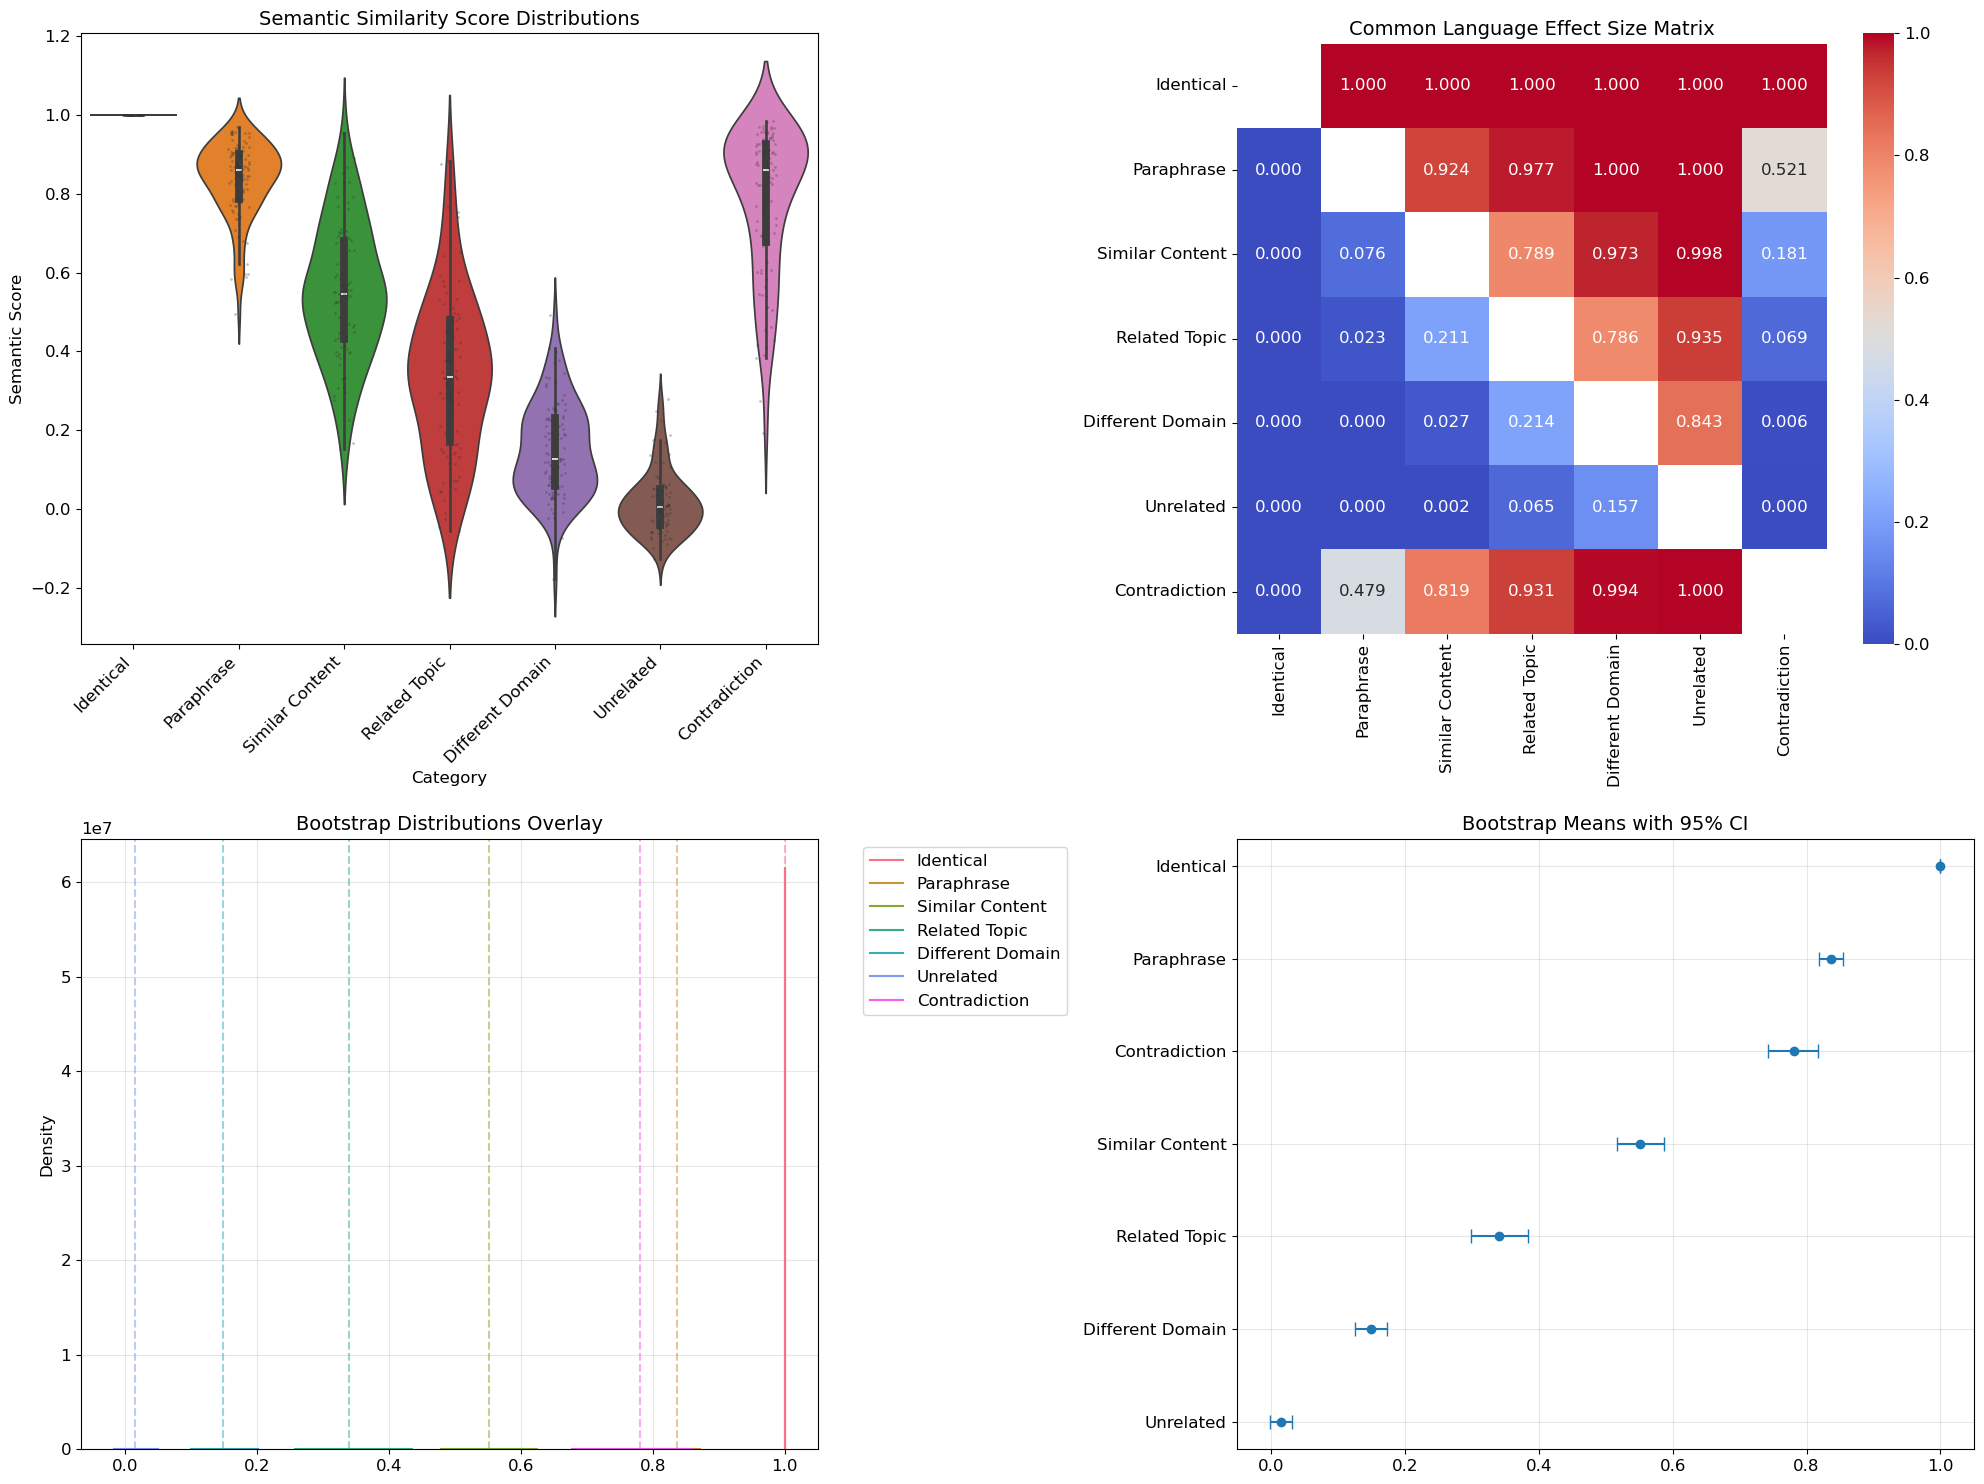

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Import revised SemScore modules
from semscore.metric.core import SemScoreMetric
from semscore.characterization.distributions import (
    analyze_category_distributions,
    generate_bootstrap_distributions,
    calculate_effect_matrices
)

# Set plotting style
# plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Create output directory structure
base_dir = Path('semscore_characterization_results')
figures_dir = base_dir / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

# Load characterization dataset
data_path = Path('semscore/data/characterization/SemScore_Characterization_Dataset.json')
with open(data_path, 'r') as f:
    raw_data = json.load(f)

# Initialize metric and compute scores
metric = SemScoreMetric()
category_scores = {}
for item in raw_data:
    category = item['category']
    score = metric(item['text1'], item['text2'])
    if category not in category_scores:
        category_scores[category] = []
    category_scores[category].append(score)

# Convert to numpy arrays
scores = {cat: np.array(scores) for cat, scores in category_scores.items()}

# Create figure grid
fig = plt.figure(figsize=(20, 15))
gs = plt.GridSpec(2, 2)

# 1. Category Distribution Plot (top left)
ax1 = fig.add_subplot(gs[0, 0])
colors = sns.color_palette("husl", n_colors=len(scores))

# Plot violin plots with individual points
plot_data = []
categories = []
for cat, data in scores.items():
    plot_data.extend(data)
    categories.extend([cat] * len(data))

df = pd.DataFrame({
    'Category': categories,
    'Semantic Score': plot_data
})

# Fix deprecated warning and overcrowding
sns.violinplot(data=df, x='Category', y='Semantic Score', 
               inner='box', hue='Category', legend=False)
# Use stripplot instead of swarmplot for better point placement
sns.stripplot(data=df, x='Category', y='Semantic Score', 
             color='0.2', alpha=0.3, size=2, jitter=True)

plt.xticks(rotation=45, ha='right')
ax1.set_title('Semantic Similarity Score Distributions')

# 2. CLES Matrix Heatmap (top right)
ax2 = fig.add_subplot(gs[0, 1])
d_matrix, cles_matrix = calculate_effect_matrices(scores)

mask = np.zeros_like(cles_matrix, dtype=bool)
np.fill_diagonal(mask, True)

sns.heatmap(cles_matrix, 
            annot=True, 
            cmap='coolwarm',
            center=0.5,
            mask=mask,
            fmt='.3f',
            square=True,
            ax=ax2)
ax2.set_title('Common Language Effect Size Matrix')

# 3. Bootstrap Distribution Plots (bottom)
bootstrap_data = generate_bootstrap_distributions(
    scores,
    n_bootstrap=10000,
    random_state=42
)

# Overlay plot (bottom left)
ax3 = fig.add_subplot(gs[1, 0])
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    sns.kdeplot(data=dist, 
                label=category,
                color=colors[idx],
                ax=ax3)
    
    # Add mean line
    mean = np.mean(dist)
    ax3.axvline(mean, color=colors[idx], linestyle='--', alpha=0.5)

ax3.set_title('Bootstrap Distributions Overlay')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# Statistical summary plot (bottom right)
ax4 = fig.add_subplot(gs[1, 1])
stats_data = []
for category, dist in bootstrap_data.items():
    mean = np.mean(dist)
    ci = np.percentile(dist, [2.5, 97.5])
    stats_data.append({
        'Category': category,
        'Mean': mean,
        'CI_Lower': ci[0],
        'CI_Upper': ci[1]
    })

stats_df = pd.DataFrame(stats_data)
stats_df = stats_df.sort_values('Mean', ascending=True)

# Plot mean and CI
ax4.errorbar(stats_df['Mean'], 
             range(len(stats_df)),
             xerr=[(stats_df['Mean'] - stats_df['CI_Lower']),
                   (stats_df['CI_Upper'] - stats_df['Mean'])],
             fmt='o',
             capsize=5)

ax4.set_yticks(range(len(stats_df)))
ax4.set_yticklabels(stats_df['Category'])
ax4.set_title('Bootstrap Means with 95% CI')
ax4.grid(True, alpha=0.3)

# Adjust layout and save
plt.tight_layout()
plt.savefig(figures_dir / 'characterization_summary.png', 
            dpi=300, bbox_inches='tight')

# Save individual plots for detailed viewing
# Distribution plot
plt.figure(figsize=(12, 8))
sns.violinplot(data=df, x='Category', y='Semantic Score', 
               inner='box', hue='Category', legend=False)
sns.stripplot(data=df, x='Category', y='Semantic Score', 
             color='0.2', alpha=0.3, size=2, jitter=True)
plt.xticks(rotation=45, ha='right')
plt.title('Semantic Similarity Score Distributions')
plt.tight_layout()
plt.savefig(figures_dir / 'category_distributions.png', 
            dpi=300, bbox_inches='tight')
plt.close()

# CLES Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cles_matrix, 
            annot=True, 
            cmap='coolwarm',
            center=0.5,
            mask=mask,
            fmt='.3f',
            square=True)
plt.title('Common Language Effect Size Matrix')
plt.tight_layout()
plt.savefig(figures_dir / 'cles_matrix.png', 
            dpi=300, bbox_inches='tight')
plt.close()

# Bootstrap distributions
plt.figure(figsize=(15, 10))
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    sns.kdeplot(data=dist, 
                label=category,
                color=colors[idx])
    mean = np.mean(dist)
    plt.axvline(mean, color=colors[idx], linestyle='--', alpha=0.5)
plt.title('Bootstrap Distributions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(figures_dir / 'bootstrap_distributions.png', 
            dpi=300, bbox_inches='tight')
plt.close()

print(f"Figures saved to {figures_dir}")

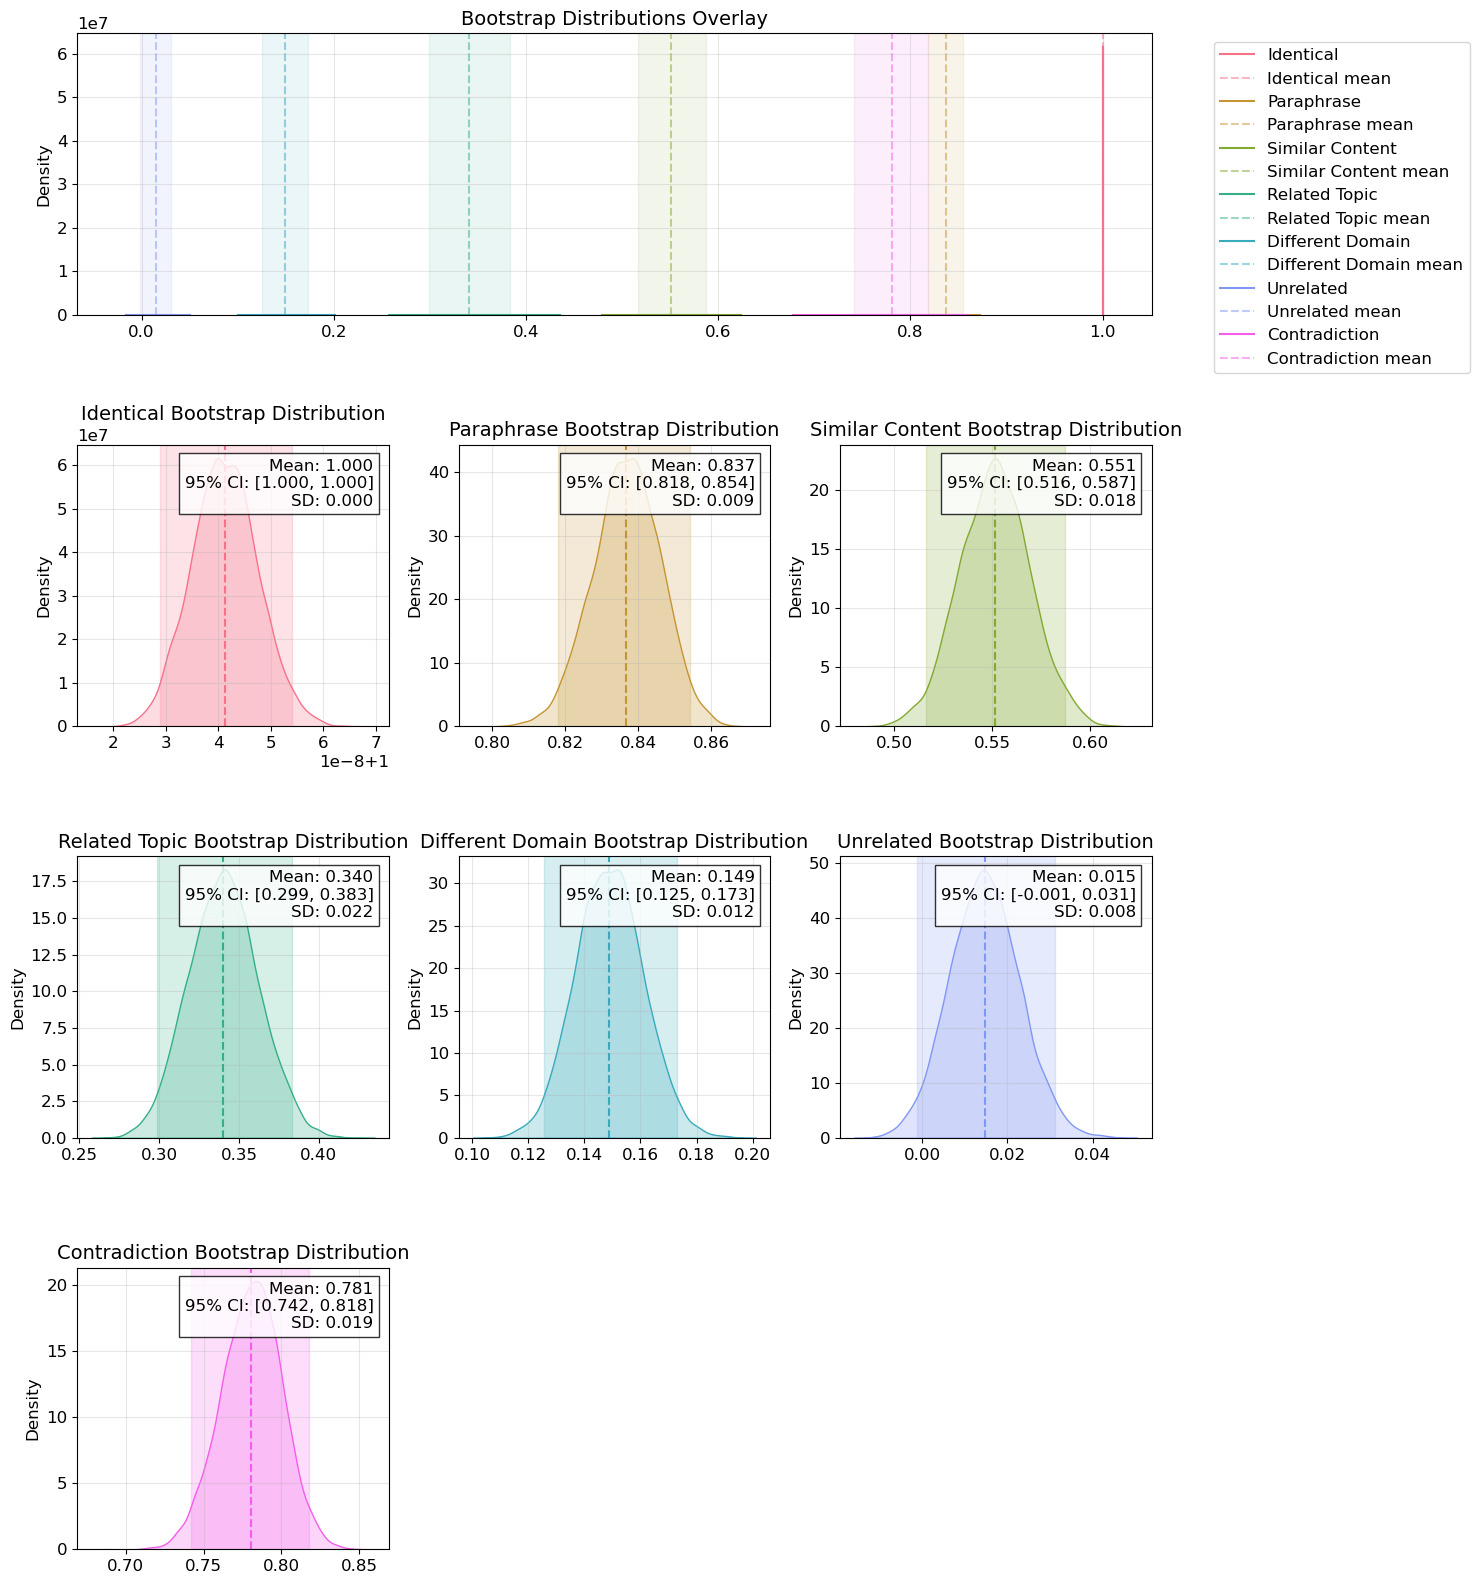

Detailed bootstrap analysis saved to semscore_characterization_results\figures/bootstrap_distributions_detailed.png


In [5]:
# Detailed Bootstrap Distribution Analysis
# Create subplot grid for individual bootstrap distributions
n_cats = len(bootstrap_data)
n_cols = 3
n_rows = (n_cats - 1) // n_cols + 2  # +1 for overlay plot

fig = plt.figure(figsize=(15, n_rows * 4))
gs = plt.GridSpec(n_rows, n_cols)

# Overlay plot (top row)
ax_overlay = fig.add_subplot(gs[0, :])
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    sns.kdeplot(data=dist, 
                label=category,
                color=colors[idx])
    
    # Add mean line and CI
    mean = np.mean(dist)
    ci = np.percentile(dist, [2.5, 97.5])
    ax_overlay.axvline(mean, color=colors[idx], linestyle='--', alpha=0.5,
                      label=f'{category} mean')
    ax_overlay.axvspan(ci[0], ci[1], color=colors[idx], alpha=0.1)

ax_overlay.set_title('Bootstrap Distributions Overlay')
ax_overlay.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax_overlay.grid(True, alpha=0.3)

# Individual distribution plots
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    row = 1 + idx // n_cols
    col = idx % n_cols
    
    ax = fig.add_subplot(gs[row, col])
    
    # Plot distribution
    sns.kdeplot(data=dist, color=colors[idx], fill=True)
    
    # Add mean and CI lines
    mean = np.mean(dist)
    ci = np.percentile(dist, [2.5, 97.5])
    
    ax.axvline(mean, color=colors[idx], linestyle='--', 
               label=f'Mean: {mean:.3f}')
    ax.axvspan(ci[0], ci[1], color=colors[idx], alpha=0.2,
               label=f'95% CI')
    
    # Add statistical annotations
    stats_text = (f'Mean: {mean:.3f}\n'
                 f'95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]\n'
                 f'SD: {np.std(dist):.3f}')
    
    ax.text(0.95, 0.95, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8))
    
    ax.set_title(f'{category} Bootstrap Distribution')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'bootstrap_distributions_detailed.png', 
            dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"Detailed bootstrap analysis saved to {figures_dir}/bootstrap_distributions_detailed.png")